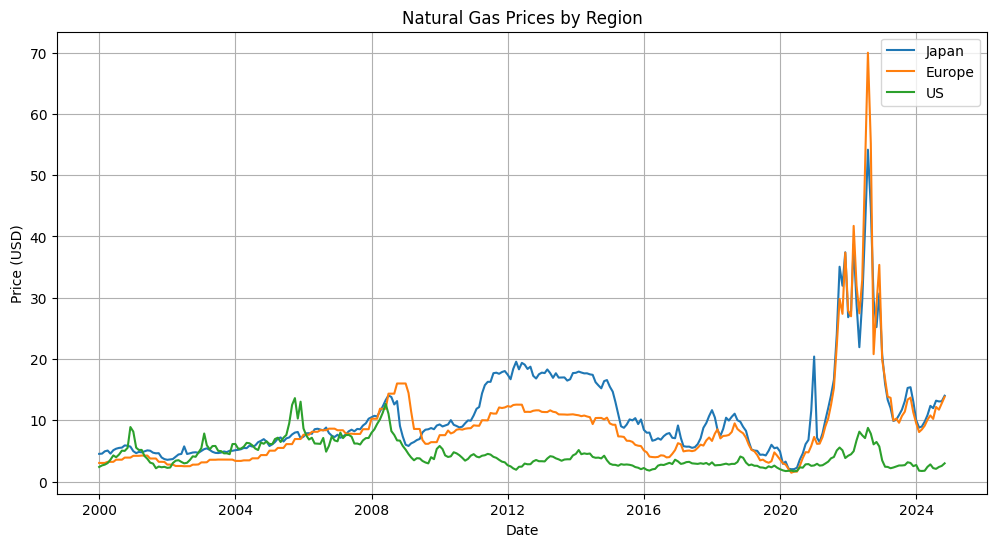

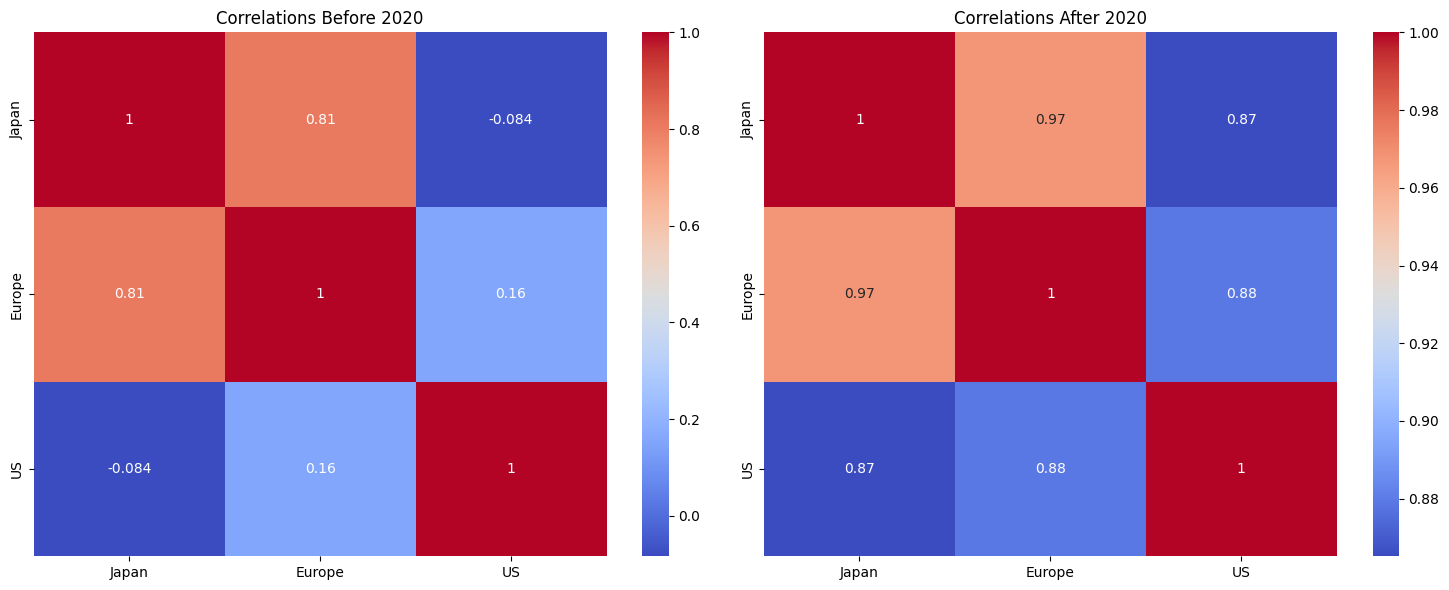


Correlation Changes (After 2020 - Before 2020):
           Japan    Europe        US
Japan   0.000000  0.162095  0.948922
Europe  0.162095  0.000000  0.724176
US      0.948922  0.724176  0.000000

Summary Statistics:

Before 2020:
            Japan      Europe          US
count  240.000000  240.000000  240.000000
mean     9.303874    7.186155    4.570243
std      4.488659    3.292753    2.193183
min      3.570000    2.520000    1.812609
25%      5.690101    4.035000    2.930227
50%      8.030000    7.112899    3.964951
75%     10.862500    9.504720    5.825420
max     19.570000   16.020000   13.633810

After 2020:
           Japan     Europe         US
count  59.000000  59.000000  59.000000
mean   16.322141  16.116249   3.491018
std    11.860239  14.177942   1.843643
min     2.032143   1.462612   1.699545
25%     8.907750   7.292772   2.327847
50%    13.051750  11.296291   2.700476
75%    23.000341  21.519732   4.132803
max    54.157500  69.977239   8.777391


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': datetime.now().strftime('%Y-%m-%d'),
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['date', 'value']]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

def analyze_correlations(df, split_date='2020-01-01'):
    # Split the data into before and after 2020
    before_2020 = df[df.index < split_date].corr()
    after_2020 = df[df.index >= split_date].corr()

    # Create correlation heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    sns.heatmap(before_2020, annot=True, cmap='coolwarm', ax=ax1)
    ax1.set_title('Correlations Before 2020')

    sns.heatmap(after_2020, annot=True, cmap='coolwarm', ax=ax2)
    ax2.set_title('Correlations After 2020')

    plt.tight_layout()
    plt.show()

    return before_2020, after_2020

def main():
    # Replace with your FRED API key
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Series IDs
    series_ids = {
        'Japan': 'PNGASJPUSDM',
        'Europe': 'PNGASEUUSDM',
        'US': 'PNGASUSUSDM'
    }

    # Fetch data for all series
    dfs = {}
    for region, series_id in series_ids.items():
        df = fetch_fred_data(series_id, api_key)
        if df is not None:
            dfs[region] = df

    # Combine all series into one dataframe
    combined_df = pd.DataFrame()
    for region, df in dfs.items():
        df = df.set_index('date')
        combined_df[region] = df['value']

    # Plot the time series
    plt.figure(figsize=(12, 6))
    for region in combined_df.columns:
        plt.plot(combined_df.index, combined_df[region], label=region)

    plt.title('Natural Gas Prices by Region')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Analyze correlations
    before_2020, after_2020 = analyze_correlations(combined_df)

    # Print correlation changes
    print("\nCorrelation Changes (After 2020 - Before 2020):")
    correlation_change = after_2020 - before_2020
    print(correlation_change)

    # Calculate summary statistics
    print("\nSummary Statistics:")
    for period, df_subset in [("Before 2020", combined_df[combined_df.index < '2020-01-01']),
                            ("After 2020", combined_df[combined_df.index >= '2020-01-01'])]:
        print(f"\n{period}:")
        print(df_subset.describe())

if __name__ == "__main__":
    main()


Animation saved as 'gas_prices.gif'


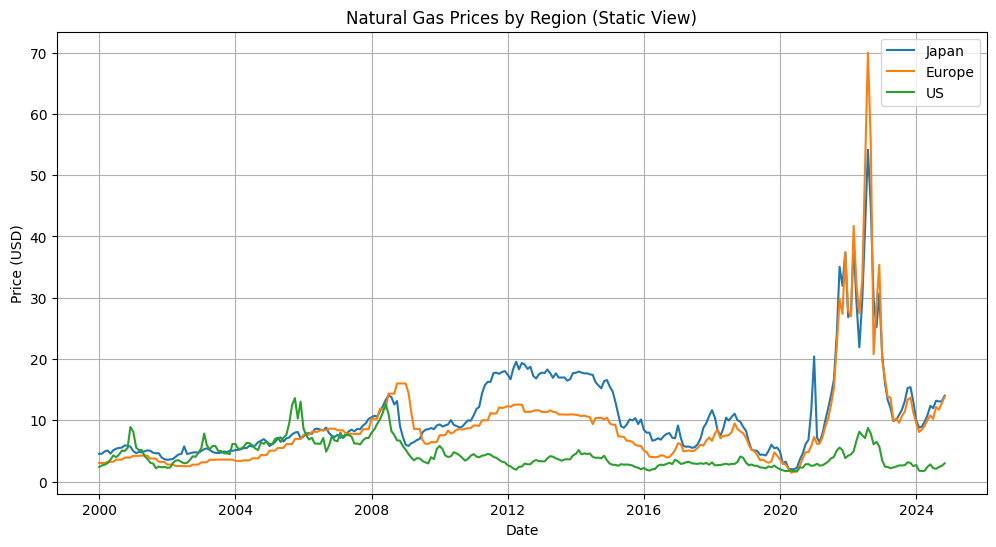

In [4]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from IPython.display import HTML

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': datetime.now().strftime('%Y-%m-%d'),
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['date', 'value']]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

def create_animation(combined_df):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set the axis limits
    ax.set_xlim(combined_df.index.min(), combined_df.index.max())
    ax.set_ylim(0, combined_df.max().max() * 1.1)

    # Initialize lines
    lines = {}
    for region in combined_df.columns:
        line, = ax.plot([], [], label=region)
        lines[region] = line

    # Add title and labels
    ax.set_title('Natural Gas Prices Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.legend()

    # Animation function
    def animate(frame):
        # Update data for each line
        for region in combined_df.columns:
            lines[region].set_data(
                combined_df.index[:frame],
                combined_df[region].iloc[:frame]
            )
        return lines.values()

    # Create animation
    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=len(combined_df),
        interval=50,  # 50ms between frames
        blit=True,
        repeat=False
    )

    # Save animation
    anim.save('gas_prices.gif', writer='pillow')
    plt.close()

def main():
    # Replace with your FRED API key
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Series IDs
    series_ids = {
        'Japan': 'PNGASJPUSDM',
        'Europe': 'PNGASEUUSDM',
        'US': 'PNGASUSUSDM'
    }

    # Fetch data for all series
    dfs = {}
    for region, series_id in series_ids.items():
        df = fetch_fred_data(series_id, api_key)
        if df is not None:
            dfs[region] = df

    # Combine all series into one dataframe
    combined_df = pd.DataFrame()
    for region, df in dfs.items():
        df = df.set_index('date')
        combined_df[region] = df['value']

    # Create and save the animation
    create_animation(combined_df)
    print("Animation saved as 'gas_prices.gif'")

    # Additional static visualization for comparison
    plt.figure(figsize=(12, 6))
    for region in combined_df.columns:
        plt.plot(combined_df.index, combined_df[region], label=region)

    plt.title('Natural Gas Prices by Region (Static View)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


In [5]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from IPython.display import HTML

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': datetime.now().strftime('%Y-%m-%d'),
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['date', 'value']]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

def create_animation(combined_df):
    # Set style for better visibility


    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Set the axis limits
    ax.set_xlim(combined_df.index.min(), combined_df.index.max())
    ax.set_ylim(0, combined_df.max().max() * 1.1)

    # Initialize lines with different colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Default matplotlib colors
    lines = {}
    for i, region in enumerate(combined_df.columns):
        line, = ax.plot([], [], label=region, color=colors[i], linewidth=2)
        lines[region] = line

    # Add title and labels
    ax.set_title('Natural Gas Prices Over Time', fontsize=12, pad=20)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price (USD)', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Create legend in upper left and fix its position
    leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9)
    leg.set_zorder(100)  # Ensure legend stays on top

    # Animation function
    def animate(frame):
        # Update data for each line
        for region in combined_df.columns:
            lines[region].set_data(
                combined_df.index[:frame],
                combined_df[region].iloc[:frame]
            )
        # Don't return the legend in the animation update
        return lines.values()

    # Create animation
    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=len(combined_df),
        interval=50,
        blit=True,
        repeat=False
    )

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    # Save animation with higher DPI for better quality
    anim.save('gas_prices.gif',
              writer='pillow',
              dpi=150,)
    plt.close()

def main():
    # Replace with your FRED API key
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Series IDs
    series_ids = {
        'Japan': 'PNGASJPUSDM',
        'Europe': 'PNGASEUUSDM',
        'US': 'PNGASUSUSDM'
    }

    # Fetch data for all series
    dfs = {}
    for region, series_id in series_ids.items():
        df = fetch_fred_data(series_id, api_key)
        if df is not None:
            dfs[region] = df

    # Combine all series into one dataframe
    combined_df = pd.DataFrame()
    for region, df in dfs.items():
        df = df.set_index('date')
        combined_df[region] = df['value']

    # Create and save the animation
    print("Creating animation...")
    create_animation(combined_df)
    print("Animation saved as 'gas_prices.gif'")

if __name__ == "__main__":
    main()


Creating animation...
Saving frame 0 of 299
Saving frame 1 of 299
Saving frame 2 of 299
Saving frame 3 of 299
Saving frame 4 of 299
Saving frame 5 of 299
Saving frame 6 of 299
Saving frame 7 of 299
Saving frame 8 of 299
Saving frame 9 of 299
Saving frame 10 of 299
Saving frame 11 of 299
Saving frame 12 of 299
Saving frame 13 of 299
Saving frame 14 of 299
Saving frame 15 of 299
Saving frame 16 of 299
Saving frame 17 of 299
Saving frame 18 of 299
Saving frame 19 of 299
Saving frame 20 of 299
Saving frame 21 of 299
Saving frame 22 of 299
Saving frame 23 of 299
Saving frame 24 of 299
Saving frame 25 of 299
Saving frame 26 of 299
Saving frame 27 of 299
Saving frame 28 of 299
Saving frame 29 of 299
Saving frame 30 of 299
Saving frame 31 of 299
Saving frame 32 of 299
Saving frame 33 of 299
Saving frame 34 of 299
Saving frame 35 of 299
Saving frame 36 of 299
Saving frame 37 of 299
Saving frame 38 of 299
Saving frame 39 of 299
Saving frame 40 of 299
Saving frame 41 of 299
Saving frame 42 of 299

In [7]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
from arch import arch_model
from IPython.display import HTML

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': datetime.now().strftime('%Y-%m-%d'),
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['date', 'value']]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

def calculate_garch_volatility(returns):
    """Calculate volatility using GARCH(1,1) model"""
    model = arch_model(returns, vol='Garch', p=1, q=1)
    results = model.fit(disp='off')
    return np.sqrt(results.conditional_volatility)

def prepare_volatility_data(combined_df):
    """Calculate returns and volatility for each series"""
    volatility_df = pd.DataFrame(index=combined_df.index)

    for region in combined_df.columns:
        # Calculate returns
        returns = np.log(combined_df[region]).diff()

        # Calculate rolling volatility (traditional method)
        rolling_vol = returns.rolling(window=20).std() * np.sqrt(252)

        # Calculate GARCH volatility
        garch_vol = calculate_garch_volatility(returns.dropna())

        # Store both volatilities
        volatility_df[f'{region}_Rolling'] = rolling_vol
        volatility_df[f'{region}_GARCH'] = garch_vol

    return volatility_df

def create_volatility_animation(volatility_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Set up the axes with separate y-axis limits for each plot
    # Rolling volatility limits
    rolling_cols = [col for col in volatility_df.columns if 'Rolling' in col]
    rolling_min = volatility_df[rolling_cols].min().min()
    rolling_max = volatility_df[rolling_cols].max().max()

    # GARCH volatility limits
    garch_cols = [col for col in volatility_df.columns if 'GARCH' in col]
    garch_min = volatility_df[garch_cols].min().min()
    garch_max = volatility_df[garch_cols].max().max()

    # Set x limits for both plots
    ax1.set_xlim(volatility_df.index.min(), volatility_df.index.max())
    ax2.set_xlim(volatility_df.index.min(), volatility_df.index.max())

    # Set y limits with some padding
    ax1.set_ylim(rolling_min * 0.9, rolling_max * 1.1)
    ax2.set_ylim(garch_min * 0.9, garch_max * 1.1)

    for ax in [ax1, ax2]:
        ax.grid(True, alpha=0.3)

    # Initialize lines
    rolling_lines = {}
    garch_lines = {}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, region in enumerate(['Japan', 'Europe', 'US']):
        # Rolling volatility lines
        roll_line, = ax1.plot([], [],
                             label=f'{region} Rolling',
                             color=colors[i],
                             linewidth=2)
        rolling_lines[region] = roll_line

        # GARCH volatility lines
        garch_line, = ax2.plot([], [],
                              label=f'{region} GARCH',
                              color=colors[i],
                              linewidth=2)
        garch_lines[region] = garch_line

    # Set titles and labels
    ax1.set_title('Rolling Volatility (20-day window)', fontsize=12)
    ax2.set_title('GARCH(1,1) Volatility', fontsize=12)
    ax2.set_xlabel('Date', fontsize=10)

    for ax in [ax1, ax2]:
        ax.set_ylabel('Annualized Volatility', fontsize=10)
        leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9)
        leg.set_zorder(100)

    def animate(frame):
        # Update both rolling and GARCH volatility lines
        for region in ['Japan', 'Europe', 'US']:
            rolling_lines[region].set_data(
                volatility_df.index[:frame],
                volatility_df[f'{region}_Rolling'].iloc[:frame]
            )
            garch_lines[region].set_data(
                volatility_df.index[:frame],
                volatility_df[f'{region}_GARCH'].iloc[:frame]
            )
        return list(rolling_lines.values()) + list(garch_lines.values())

    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=len(volatility_df),
        interval=50,
        blit=True,
        repeat=False
    )

    plt.tight_layout()
    anim.save('gas_volatility.gif', writer='pillow', dpi=150)
    plt.close()

    # Print the scale ranges for verification
    print("\nScale Ranges:")
    print(f"Rolling Volatility: {rolling_min:.4f} to {rolling_max:.4f}")
    print(f"GARCH Volatility: {garch_min:.4f} to {garch_max:.4f}")


def main():
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    series_ids = {
        'Japan': 'PNGASJPUSDM',
        'Europe': 'PNGASEUUSDM',
        'US': 'PNGASUSUSDM'
    }

    # Fetch and prepare data
    dfs = {}
    for region, series_id in series_ids.items():
        df = fetch_fred_data(series_id, api_key)
        if df is not None:
            dfs[region] = df

    combined_df = pd.DataFrame()
    for region, df in dfs.items():
        df = df.set_index('date')
        combined_df[region] = df['value']

    # Calculate volatilities
    print("Calculating volatilities...")
    volatility_df = prepare_volatility_data(combined_df)

    # Create and save the animation
    print("Creating animation...")
    create_volatility_animation(volatility_df)
    print("Animation saved as 'gas_volatility.gif'")

    # Print summary statistics
    print("\nVolatility Summary Statistics:")
    print(volatility_df.describe())

if __name__ == "__main__":
    main()


Calculating volatilities...
Creating animation...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01763. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y


Scale Ranges:
Rolling Volatility: 0.1913 to 6.0391
GARCH Volatility: 0.2038 to 0.8310
Animation saved as 'gas_volatility.gif'

Volatility Summary Statistics:
       Japan_Rolling  Japan_GARCH  Europe_Rolling  Europe_GARCH  US_Rolling  \
count     279.000000   298.000000      279.000000    298.000000  279.000000   
mean        1.839880     0.329159        1.623130      0.311613    2.036813   
std         1.431788     0.107621        1.354705      0.102646    0.581810   
min         0.438225     0.210828        0.191326      0.203779    1.087259   
25%         0.875020     0.253972        0.721721      0.236405    1.593106   
50%         1.401733     0.288342        1.051375      0.278314    1.810910   
75%         2.004957     0.366815        1.849151      0.349991    2.421826   
max         6.039096     0.830993        5.892048      0.720617    3.359948   

         US_GARCH  
count  298.000000  
mean     0.363775  
std      0.030050  
min      0.314722  
25%      0.336811  
50%      

In [3]:
def create_volatility_animation(volatility_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Set up the axes with separate y-axis limits for each plot
    # Rolling volatility limits
    rolling_cols = [col for col in volatility_df.columns if 'Rolling' in col]
    rolling_min = volatility_df[rolling_cols].min().min()
    rolling_max = volatility_df[rolling_cols].max().max()

    # GARCH volatility limits
    garch_cols = [col for col in volatility_df.columns if 'GARCH' in col]
    garch_min = volatility_df[garch_cols].min().min()
    garch_max = volatility_df[garch_cols].max().max()

    # Set x limits for both plots
    ax1.set_xlim(volatility_df.index.min(), volatility_df.index.max())
    ax2.set_xlim(volatility_df.index.min(), volatility_df.index.max())

    # Set y limits with some padding
    ax1.set_ylim(rolling_min * 0.9, rolling_max * 1.1)
    ax2.set_ylim(garch_min * 0.9, garch_max * 1.1)

    for ax in [ax1, ax2]:
        ax.grid(True, alpha=0.3)

    # Initialize lines
    rolling_lines = {}
    garch_lines = {}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for i, region in enumerate(['Japan', 'Europe', 'US']):
        # Rolling volatility lines
        roll_line, = ax1.plot([], [],
                             label=f'{region} Rolling',
                             color=colors[i],
                             linewidth=2)
        rolling_lines[region] = roll_line

        # GARCH volatility lines
        garch_line, = ax2.plot([], [],
                              label=f'{region} GARCH',
                              color=colors[i],
                              linewidth=2)
        garch_lines[region] = garch_line

    # Set titles and labels
    ax1.set_title('Rolling Volatility (20-day window)', fontsize=12)
    ax2.set_title('GARCH(1,1) Volatility', fontsize=12)
    ax2.set_xlabel('Date', fontsize=10)

    for ax in [ax1, ax2]:
        ax.set_ylabel('Annualized Volatility', fontsize=10)
        leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9)
        leg.set_zorder(100)

    def animate(frame):
        # Update both rolling and GARCH volatility lines
        for region in ['Japan', 'Europe', 'US']:
            rolling_lines[region].set_data(
                volatility_df.index[:frame],
                volatility_df[f'{region}_Rolling'].iloc[:frame]
            )
            garch_lines[region].set_data(
                volatility_df.index[:frame],
                volatility_df[f'{region}_GARCH'].iloc[:frame]
            )
        return list(rolling_lines.values()) + list(garch_lines.values())

    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=len(volatility_df),
        interval=50,
        blit=True,
        repeat=False
    )

    plt.tight_layout()
    anim.save('gas_volatility.gif', writer='pillow', dpi=150)
    plt.close()

    # Print the scale ranges for verification
    print("\nScale Ranges:")
    print(f"Rolling Volatility: {rolling_min:.4f} to {rolling_max:.4f}")
    print(f"GARCH Volatility: {garch_min:.4f} to {garch_max:.4f}")


In [4]:
create_volatility_animation(volatility_df)

NameError: name 'volatility_df' is not defined

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Create sample time series data
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
data = pd.DataFrame({
    'date': dates,
    'target': np.random.normal(100, 10, len(dates)),  # Target variable
    'feature1': np.random.normal(50, 5, len(dates))   # Legitimate feature
})

# Add a rolling mean (this will demonstrate leakage if not handled properly)
data['rolling_mean'] = data['target'].rolling(window=7, center=True).mean()

# 1. WRONG WAY - With Data Leakage
def demonstrate_leakage():
    # Randomly shuffle and split (wrong for time series!)
    X = data[['feature1', 'rolling_mean']].dropna()
    y = data['target'][X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)

# 2. CORRECT WAY - Proper Time Series Handling
def demonstrate_proper_handling():
    # Create proper time-based features (no lookahead)
    data['proper_rolling_mean'] = data['target'].rolling(window=7, min_periods=1).mean().shift(1)

    # Time-based split
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    # Use only features available at prediction time
    X_train = train_data[['feature1', 'proper_rolling_mean']].dropna()
    y_train = train_data['target'][X_train.index]

    X_test = test_data[['feature1', 'proper_rolling_mean']].dropna()
    y_test = test_data['target'][X_test.index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)

# Compare results
leakage_mse = demonstrate_leakage()
proper_mse = demonstrate_proper_handling()

print(f"MSE with data leakage: {leakage_mse:.2f}")
print(f"MSE with proper handling: {proper_mse:.2f}")
print(f"Difference in MSE: {proper_mse - leakage_mse:.2f}")


MSE with data leakage: 55.49
MSE with proper handling: 56.35
Difference in MSE: 0.86


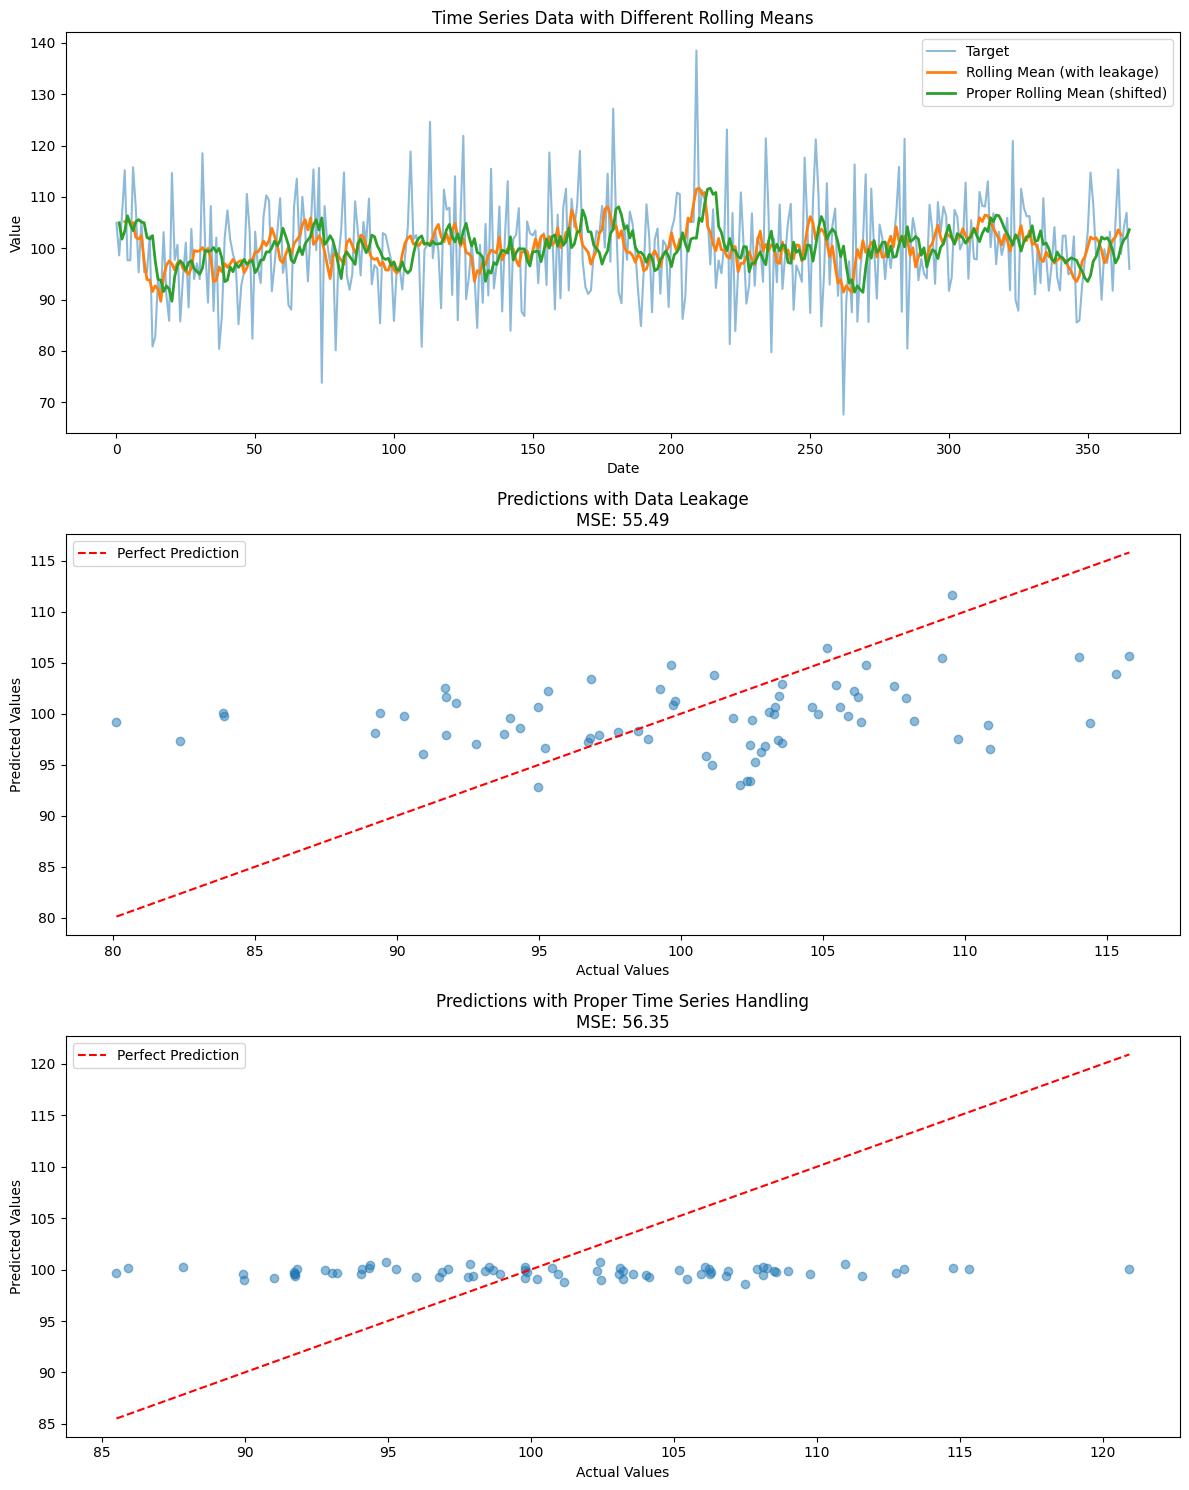

MSE with data leakage: 55.49
MSE with proper handling: 56.35
Difference in MSE: 0.86


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Create sample time series data
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
data = pd.DataFrame({
    'date': dates,
    'target': np.random.normal(100, 10, len(dates)),
    'feature1': np.random.normal(50, 5, len(dates))
})

# Add rolling means
data['rolling_mean_with_leakage'] = data['target'].rolling(window=7, center=True).mean()
data['proper_rolling_mean'] = data['target'].rolling(window=7, min_periods=1).mean().shift(1)

# 1. Model with Data Leakage
def demonstrate_leakage():
    X = data[['feature1', 'rolling_mean_with_leakage']].dropna()
    y = data['target'][X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return X_test, y_test, y_pred

# 2. Model with Proper Handling
def demonstrate_proper_handling():
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['feature1', 'proper_rolling_mean']].dropna()
    y_train = train_data['target'][X_train.index]

    X_test = test_data[['feature1', 'proper_rolling_mean']].dropna()
    y_test = test_data['target'][X_test.index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return X_test, y_test, y_pred

# Run both models
X_test_leak, y_test_leak, y_pred_leak = demonstrate_leakage()
X_test_proper, y_test_proper, y_pred_proper = demonstrate_proper_handling()

# Calculate MSE
mse_leak = mean_squared_error(y_test_leak, y_pred_leak)
mse_proper = mean_squared_error(y_test_proper, y_pred_proper)

# Create visualizations

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# 1. Original Data and Rolling Means
ax1.plot(data.index, data['target'], label='Target', alpha=0.5)
ax1.plot(data.index, data['rolling_mean_with_leakage'],
         label='Rolling Mean (with leakage)', linewidth=2)
ax1.plot(data.index, data['proper_rolling_mean'],
         label='Proper Rolling Mean (shifted)', linewidth=2)
ax1.set_title('Time Series Data with Different Rolling Means')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel('Value')

# 2. Model with Data Leakage
ax2.scatter(y_test_leak, y_pred_leak, alpha=0.5)
ax2.plot([y_test_leak.min(), y_test_leak.max()],
         [y_test_leak.min(), y_test_leak.max()],
         'r--', label='Perfect Prediction')
ax2.set_title(f'Predictions with Data Leakage\nMSE: {mse_leak:.2f}')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.legend()

# 3. Model with Proper Handling
ax3.scatter(y_test_proper, y_pred_proper, alpha=0.5)
ax3.plot([y_test_proper.min(), y_test_proper.max()],
         [y_test_proper.min(), y_test_proper.max()],
         'r--', label='Perfect Prediction')
ax3.set_title(f'Predictions with Proper Time Series Handling\nMSE: {mse_proper:.2f}')
ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted Values')
ax3.legend()

plt.tight_layout()
plt.savefig('time_series_analysis.png')
plt.show()

print(f"MSE with data leakage: {mse_leak:.2f}")
print(f"MSE with proper handling: {mse_proper:.2f}")
print(f"Difference in MSE: {mse_proper - mse_leak:.2f}")


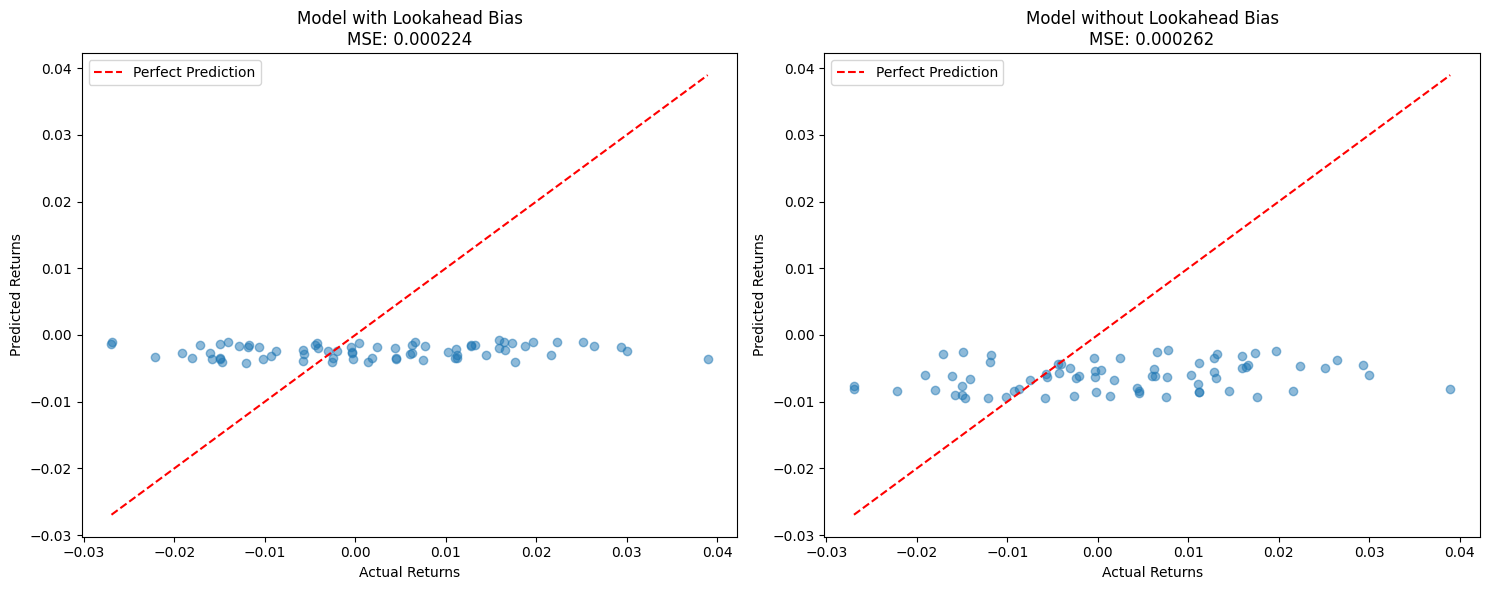

MSE with lookahead bias: 0.000224
MSE without lookahead bias: 0.000262
Performance difference (proper - lookahead): 0.000038


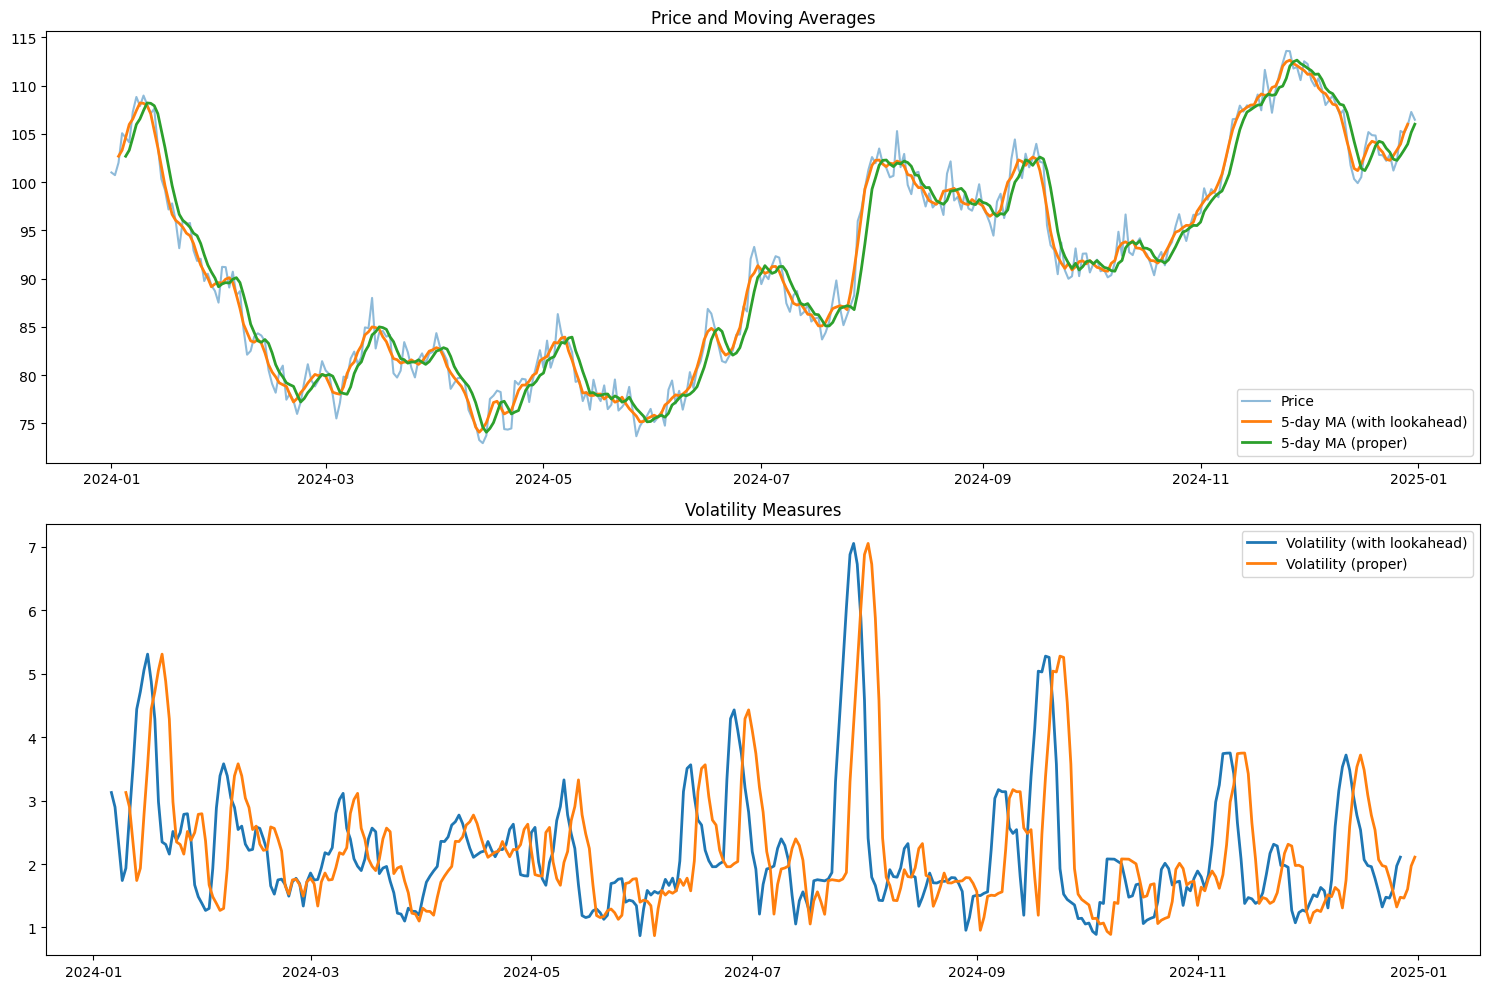

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create synthetic stock data
np.random.seed(42)
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
stock_data = pd.DataFrame({
    'date': dates,
    'price': 100 * (1 + np.random.normal(0, 0.02, len(dates)).cumsum())
})

# Function to create features (wrong way - with lookahead bias)
def create_features_with_lookahead(df):
    df['next_day_return'] = df['price'].pct_change().shift(-1)
    df['future_5day_ma'] = df['price'].rolling(window=5, center=True).mean()
    df['future_volatility'] = df['price'].rolling(window=10, center=True).std()
    return df

# Function to create features (correct way - no lookahead)
def create_features_proper(df):
    df['next_day_return'] = df['price'].pct_change().shift(-1)
    df['past_5day_ma'] = df['price'].rolling(window=5).mean()
    df['past_volatility'] = df['price'].rolling(window=10).std()
    return df

# Create both datasets
data_with_lookahead = create_features_with_lookahead(stock_data.copy())
data_proper = create_features_proper(stock_data.copy())

# Function to train and evaluate model with proper time series split
def evaluate_model(data, features, title, ax):
    # Remove NaN values
    data = data.dropna()

    # Proper time series split (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    # Prepare features and target
    X_train = train_data[features]
    y_train = train_data['next_day_return']
    X_test = test_data[features]
    y_test = test_data['next_day_return']

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Plot results
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            'r--', label='Perfect Prediction')
    ax.set_title(f'{title}\nMSE: {mse:.6f}')
    ax.set_xlabel('Actual Returns')
    ax.set_ylabel('Predicted Returns')
    ax.legend()

    return mse

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Evaluate both models
mse_lookahead = evaluate_model(
    data_with_lookahead,
    ['future_5day_ma', 'future_volatility'],
    'Model with Lookahead Bias',
    ax1
)

mse_proper = evaluate_model(
    data_proper,
    ['past_5day_ma', 'past_volatility'],
    'Model without Lookahead Bias',
    ax2
)

plt.tight_layout()
plt.show()

# Print comparison
print(f"MSE with lookahead bias: {mse_lookahead:.6f}")
print(f"MSE without lookahead bias: {mse_proper:.6f}")
print(f"Performance difference (proper - lookahead): {mse_proper - mse_lookahead:.6f}")

# Visualize the features
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot moving averages
ax1.plot(stock_data['date'], stock_data['price'], label='Price', alpha=0.5)
ax1.plot(data_with_lookahead['date'], data_with_lookahead['future_5day_ma'],
         label='5-day MA (with lookahead)', linewidth=2)
ax1.plot(data_proper['date'], data_proper['past_5day_ma'],
         label='5-day MA (proper)', linewidth=2)
ax1.set_title('Price and Moving Averages')
ax1.legend()

# Plot volatility
ax2.plot(data_with_lookahead['date'], data_with_lookahead['future_volatility'],
         label='Volatility (with lookahead)', linewidth=2)
ax2.plot(data_proper['date'], data_proper['past_volatility'],
         label='Volatility (proper)', linewidth=2)
ax2.set_title('Volatility Measures')
ax2.legend()

plt.tight_layout()
plt.show()


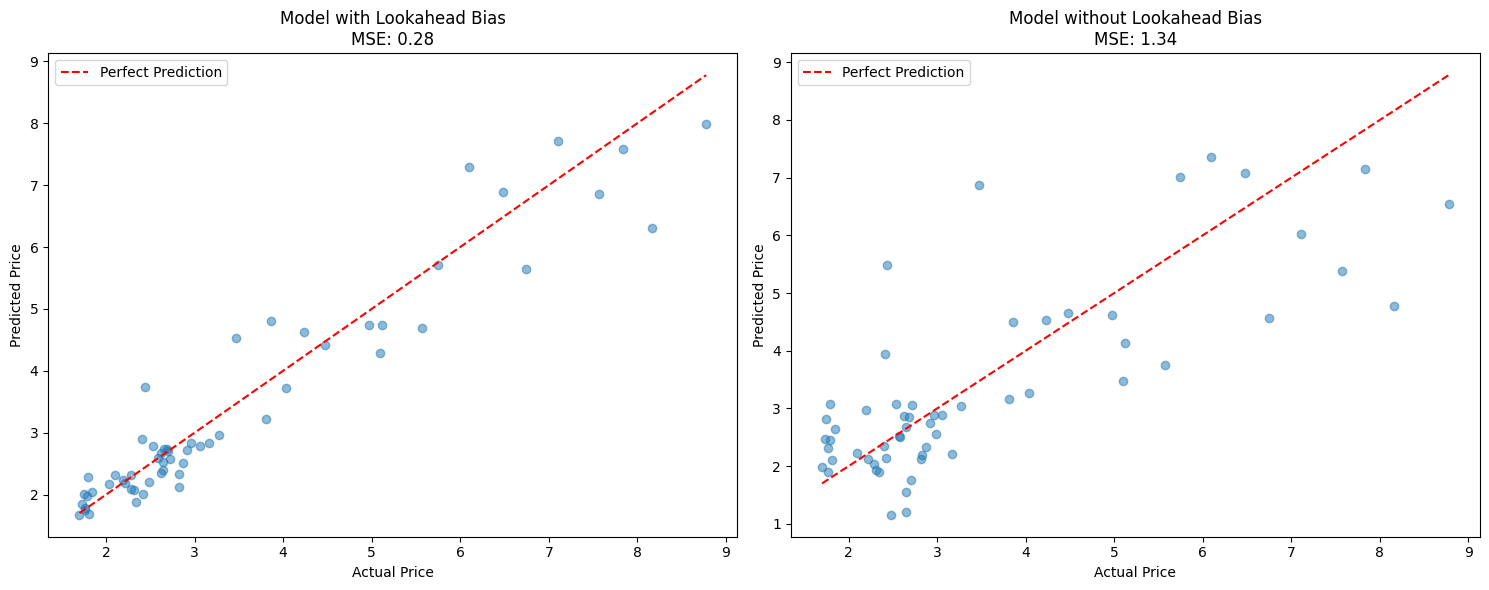

MSE with lookahead bias: 0.28
MSE without lookahead bias: 1.34
Performance difference (proper - lookahead): 1.06


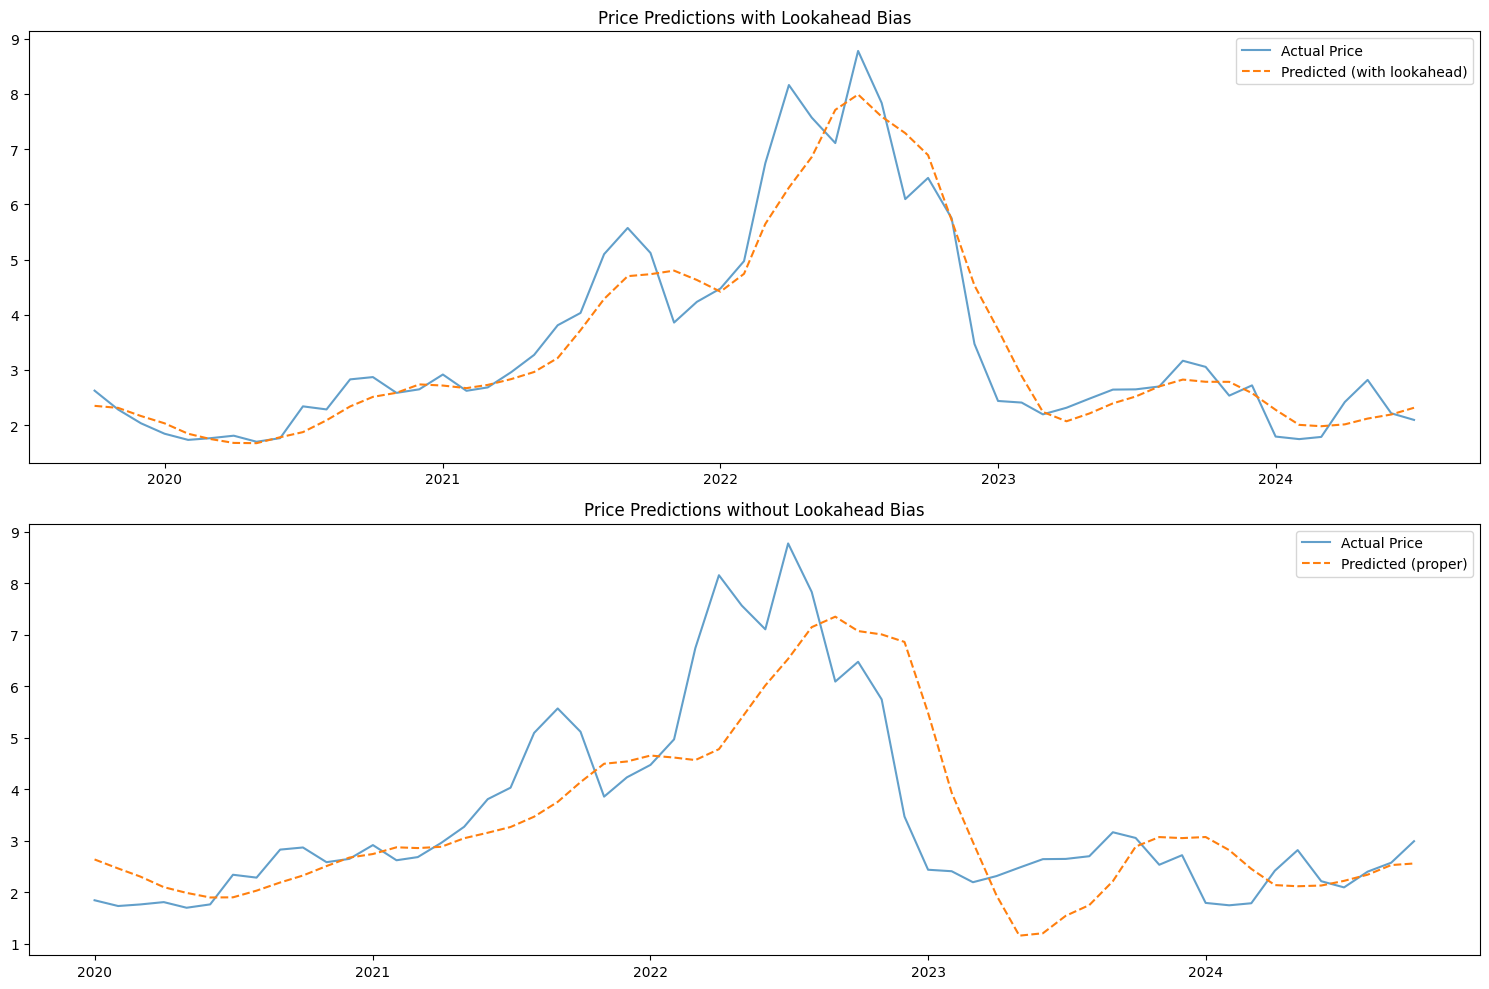

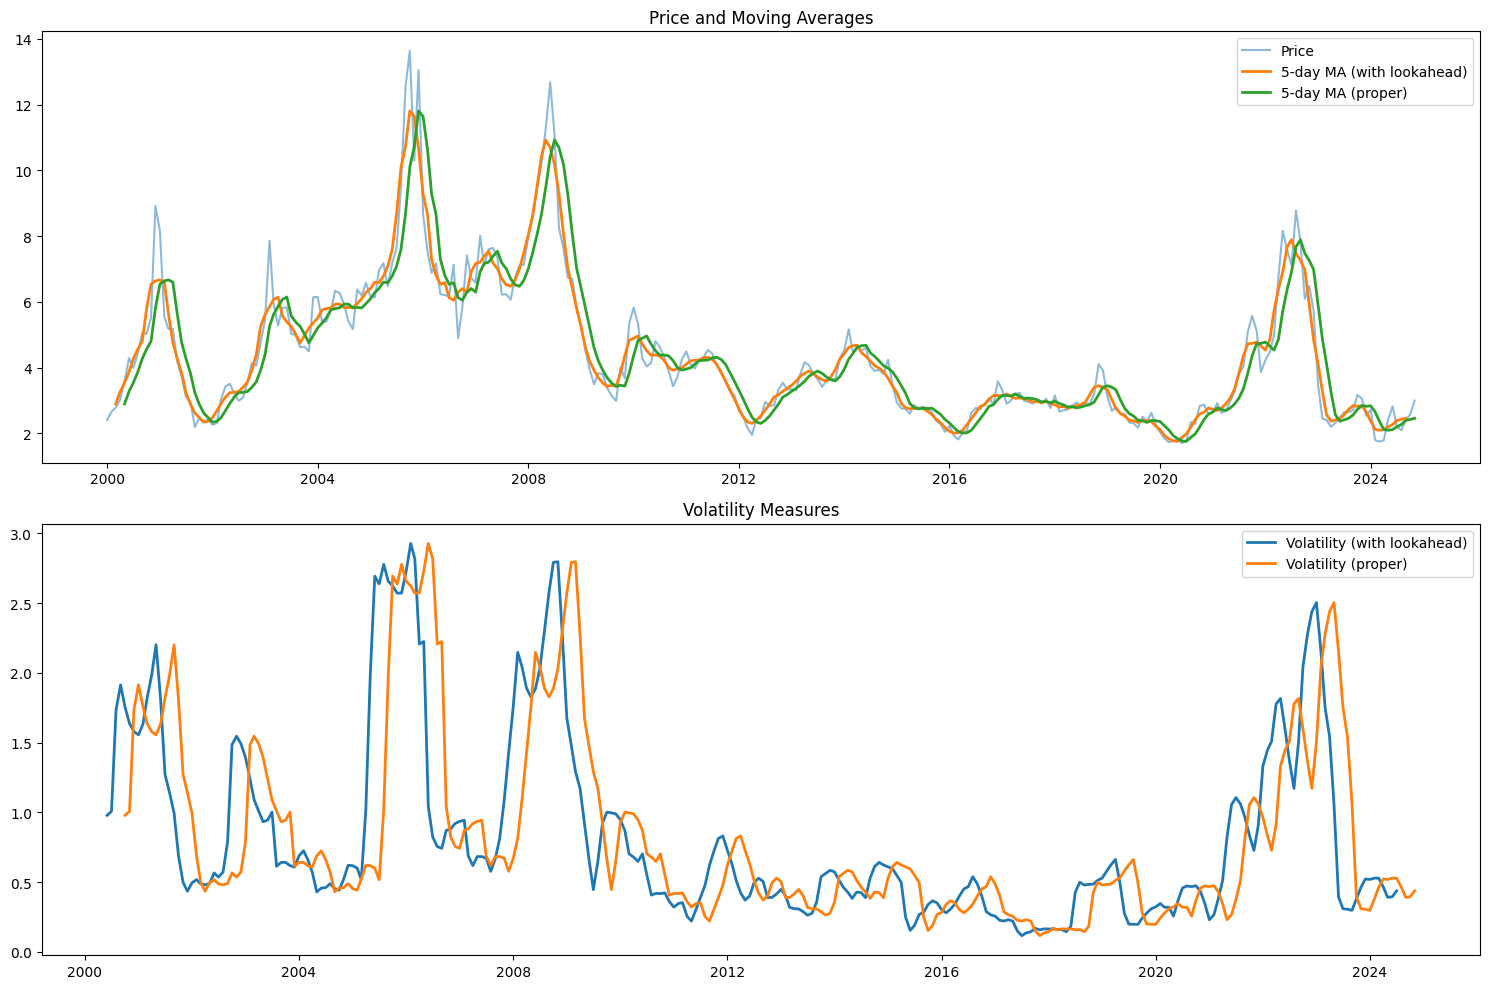

In [14]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['date', 'value']]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

# Function to create features (wrong way - with lookahead bias)
def create_features_with_lookahead(df):
    df['next_day_price'] = df['value'].shift(-1)  # Target (tomorrow's price)
    df['future_5day_ma'] = df['value'].rolling(window=5, center=True).mean()
    df['future_volatility'] = df['value'].rolling(window=10, center=True).std()
    return df

# Function to create features (correct way - no lookahead)
def create_features_proper(df):
    df['next_day_price'] = df['value'].shift(-1)  # Target (tomorrow's price)
    df['past_5day_ma'] = df['value'].rolling(window=5).mean()
    df['past_volatility'] = df['value'].rolling(window=10).std()
    return df

# Function to train and evaluate model with proper time series split
def evaluate_model(data, features, title, ax):
    # Remove NaN values
    data = data.dropna()

    # Proper time series split (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    # Prepare features and target
    X_train = train_data[features]
    y_train = train_data['next_day_price']
    X_test = test_data[features]
    y_test = test_data['next_day_price']

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Plot results
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            'r--', label='Perfect Prediction')
    ax.set_title(f'{title}\nMSE: {mse:.2f}')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()

    return mse, test_data.index, y_test, y_pred

def main():
    # FRED API key
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Fetch US Natural Gas data
    gas_data = fetch_fred_data('PNGASUSUSDM', api_key)
    gas_data = gas_data.set_index('date')

    # Create both datasets
    data_with_lookahead = create_features_with_lookahead(gas_data.copy())
    data_proper = create_features_proper(gas_data.copy())

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Evaluate both models
    mse_lookahead, test_dates_look, y_test_look, y_pred_look = evaluate_model(
        data_with_lookahead,
        ['future_5day_ma', 'future_volatility'],
        'Model with Lookahead Bias',
        ax1
    )

    mse_proper, test_dates_prop, y_test_prop, y_pred_prop = evaluate_model(
        data_proper,
        ['past_5day_ma', 'past_volatility'],
        'Model without Lookahead Bias',
        ax2
    )

    plt.tight_layout()
    plt.show()

    # Print comparison
    print(f"MSE with lookahead bias: {mse_lookahead:.2f}")
    print(f"MSE without lookahead bias: {mse_proper:.2f}")
    print(f"Performance difference (proper - lookahead): {mse_proper - mse_lookahead:.2f}")

    # Plot time series predictions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot actual vs predicted prices over time
    ax1.plot(test_dates_look, y_test_look, label='Actual Price', alpha=0.7)
    ax1.plot(test_dates_look, y_pred_look, label='Predicted (with lookahead)', linestyle='--')
    ax1.set_title('Price Predictions with Lookahead Bias')
    ax1.legend()

    ax2.plot(test_dates_prop, y_test_prop, label='Actual Price', alpha=0.7)
    ax2.plot(test_dates_prop, y_pred_prop, label='Predicted (proper)', linestyle='--')
    ax2.set_title('Price Predictions without Lookahead Bias')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Visualize the features
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot moving averages
    ax1.plot(gas_data.index, gas_data['value'], label='Price', alpha=0.5)
    ax1.plot(data_with_lookahead.index, data_with_lookahead['future_5day_ma'],
             label='5-day MA (with lookahead)', linewidth=2)
    ax1.plot(data_proper.index, data_proper['past_5day_ma'],
             label='5-day MA (proper)', linewidth=2)
    ax1.set_title('Price and Moving Averages')
    ax1.legend()

    # Plot volatility
    ax2.plot(data_with_lookahead.index, data_with_lookahead['future_volatility'],
             label='Volatility (with lookahead)', linewidth=2)
    ax2.plot(data_proper.index, data_proper['past_volatility'],
             label='Volatility (proper)', linewidth=2)
    ax2.set_title('Volatility Measures')
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()



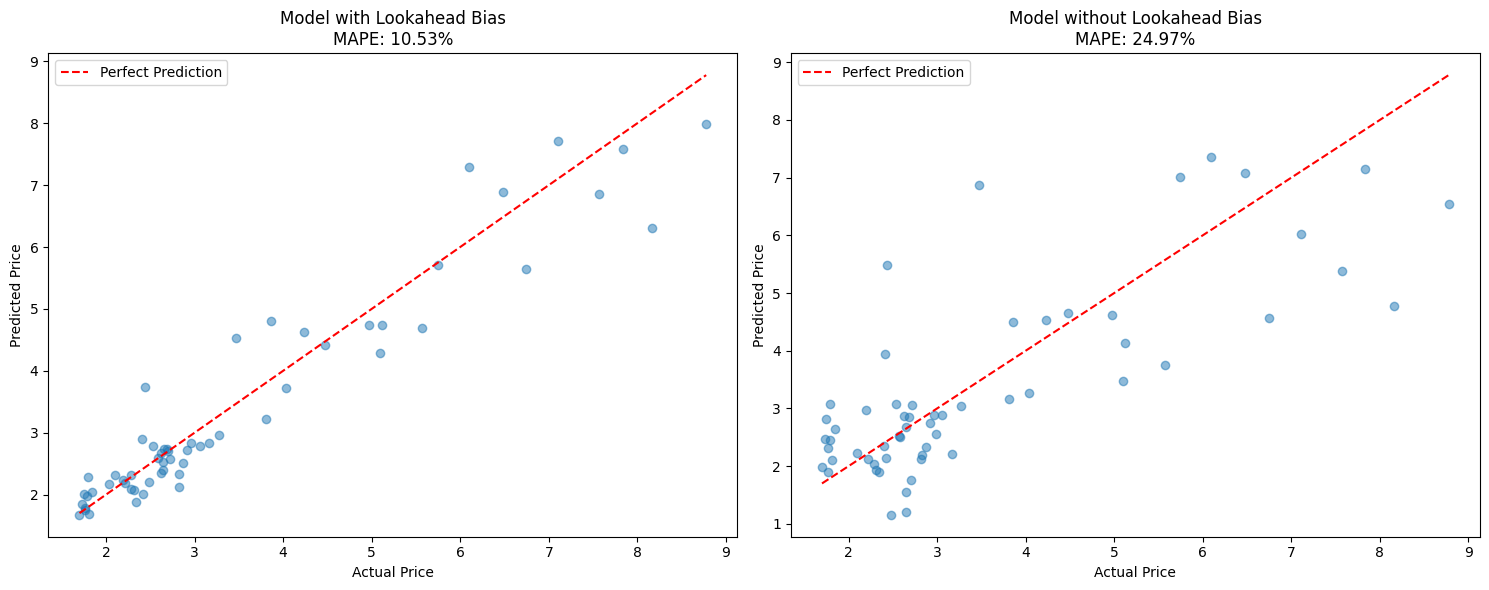

MAPE with lookahead bias: 10.53%
MAPE without lookahead bias: 24.97%
Difference in MAPE: 14.45%


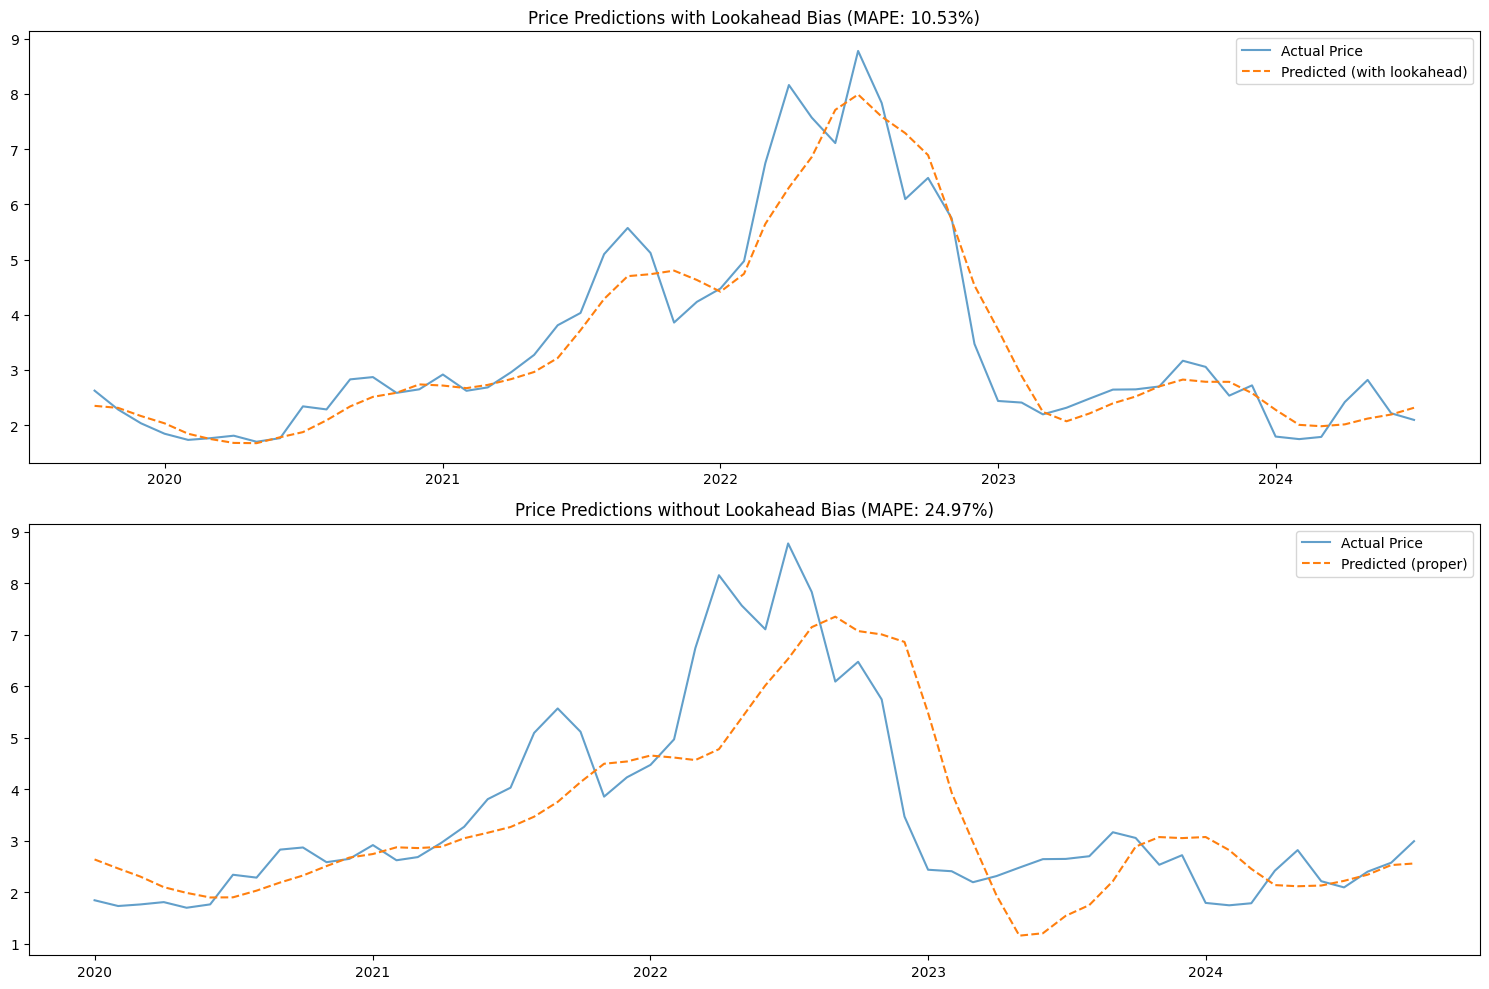

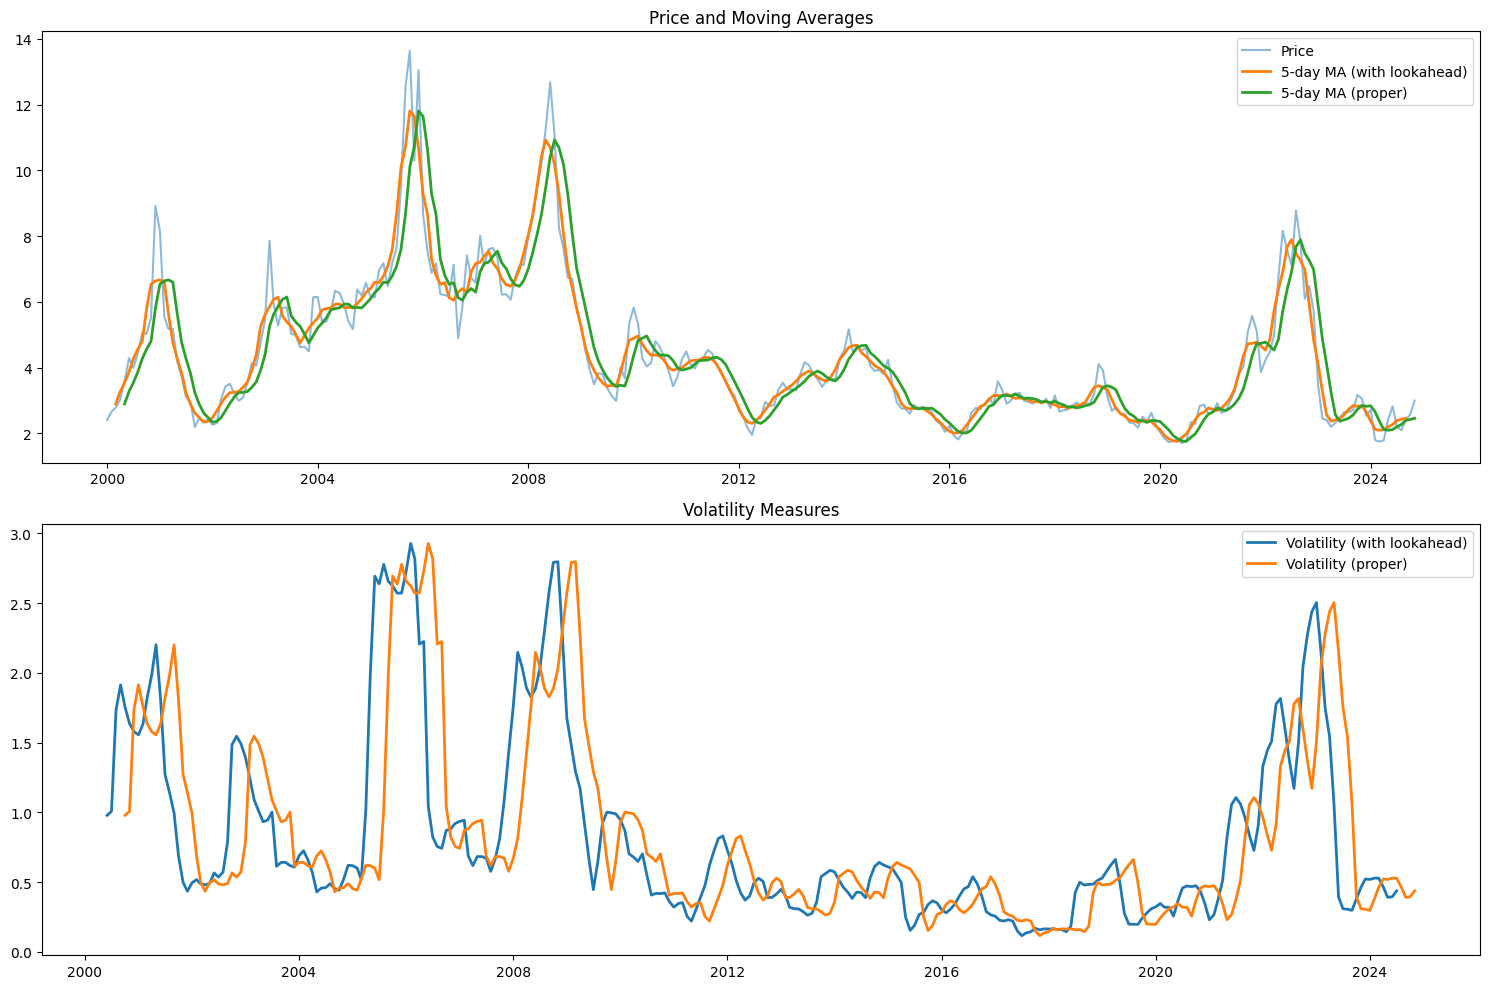

In [15]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['date', 'value']]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

# Function to create features (wrong way - with lookahead bias)
def create_features_with_lookahead(df):
    df['next_day_price'] = df['value'].shift(-1)  # Target (tomorrow's price)
    df['future_5day_ma'] = df['value'].rolling(window=5, center=True).mean()
    df['future_volatility'] = df['value'].rolling(window=10, center=True).std()
    return df

# Function to create features (correct way - no lookahead)
def create_features_proper(df):
    df['next_day_price'] = df['value'].shift(-1)  # Target (tomorrow's price)
    df['past_5day_ma'] = df['value'].rolling(window=5).mean()
    df['past_volatility'] = df['value'].rolling(window=10).std()
    return df

# Function to train and evaluate model with proper time series split
def evaluate_model(data, features, title, ax):
    # Remove NaN values
    data = data.dropna()

    # Proper time series split (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    # Prepare features and target
    X_train = train_data[features]
    y_train = train_data['next_day_price']
    X_test = test_data[features]
    y_test = test_data['next_day_price']

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    mape_score = mape(y_test, y_pred)

    # Plot results
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            'r--', label='Perfect Prediction')
    ax.set_title(f'{title}\nMAPE: {mape_score:.2f}%')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()

    return mape_score, test_data.index, y_test, y_pred

def main():
    # FRED API key
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Fetch US Natural Gas data
    gas_data = fetch_fred_data('PNGASUSUSDM', api_key)
    gas_data = gas_data.set_index('date')

    # Create both datasets
    data_with_lookahead = create_features_with_lookahead(gas_data.copy())
    data_proper = create_features_proper(gas_data.copy())

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Evaluate both models
    mape_lookahead, test_dates_look, y_test_look, y_pred_look = evaluate_model(
        data_with_lookahead,
        ['future_5day_ma', 'future_volatility'],
        'Model with Lookahead Bias',
        ax1
    )

    mape_proper, test_dates_prop, y_test_prop, y_pred_prop = evaluate_model(
        data_proper,
        ['past_5day_ma', 'past_volatility'],
        'Model without Lookahead Bias',
        ax2
    )

    plt.tight_layout()
    plt.show()

    # Print comparison
    print(f"MAPE with lookahead bias: {mape_lookahead:.2f}%")
    print(f"MAPE without lookahead bias: {mape_proper:.2f}%")
    print(f"Difference in MAPE: {mape_proper - mape_lookahead:.2f}%")

    # Plot time series predictions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot actual vs predicted prices over time
    ax1.plot(test_dates_look, y_test_look, label='Actual Price', alpha=0.7)
    ax1.plot(test_dates_look, y_pred_look, label='Predicted (with lookahead)', linestyle='--')
    ax1.set_title(f'Price Predictions with Lookahead Bias (MAPE: {mape_lookahead:.2f}%)')
    ax1.legend()

    ax2.plot(test_dates_prop, y_test_prop, label='Actual Price', alpha=0.7)
    ax2.plot(test_dates_prop, y_pred_prop, label='Predicted (proper)', linestyle='--')
    ax2.set_title(f'Price Predictions without Lookahead Bias (MAPE: {mape_proper:.2f}%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Visualize the features
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot moving averages
    ax1.plot(gas_data.index, gas_data['value'], label='Price', alpha=0.5)
    ax1.plot(data_with_lookahead.index, data_with_lookahead['future_5day_ma'],
             label='5-day MA (with lookahead)', linewidth=2)
    ax1.plot(data_proper.index, data_proper['past_5day_ma'],
             label='5-day MA (proper)', linewidth=2)
    ax1.set_title('Price and Moving Averages')
    ax1.legend()

    # Plot volatility
    ax2.plot(data_with_lookahead.index, data_with_lookahead['future_volatility'],
             label='Volatility (with lookahead)', linewidth=2)
    ax2.plot(data_proper.index, data_proper['past_volatility'],
             label='Volatility (proper)', linewidth=2)
    ax2.set_title('Volatility Measures')
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


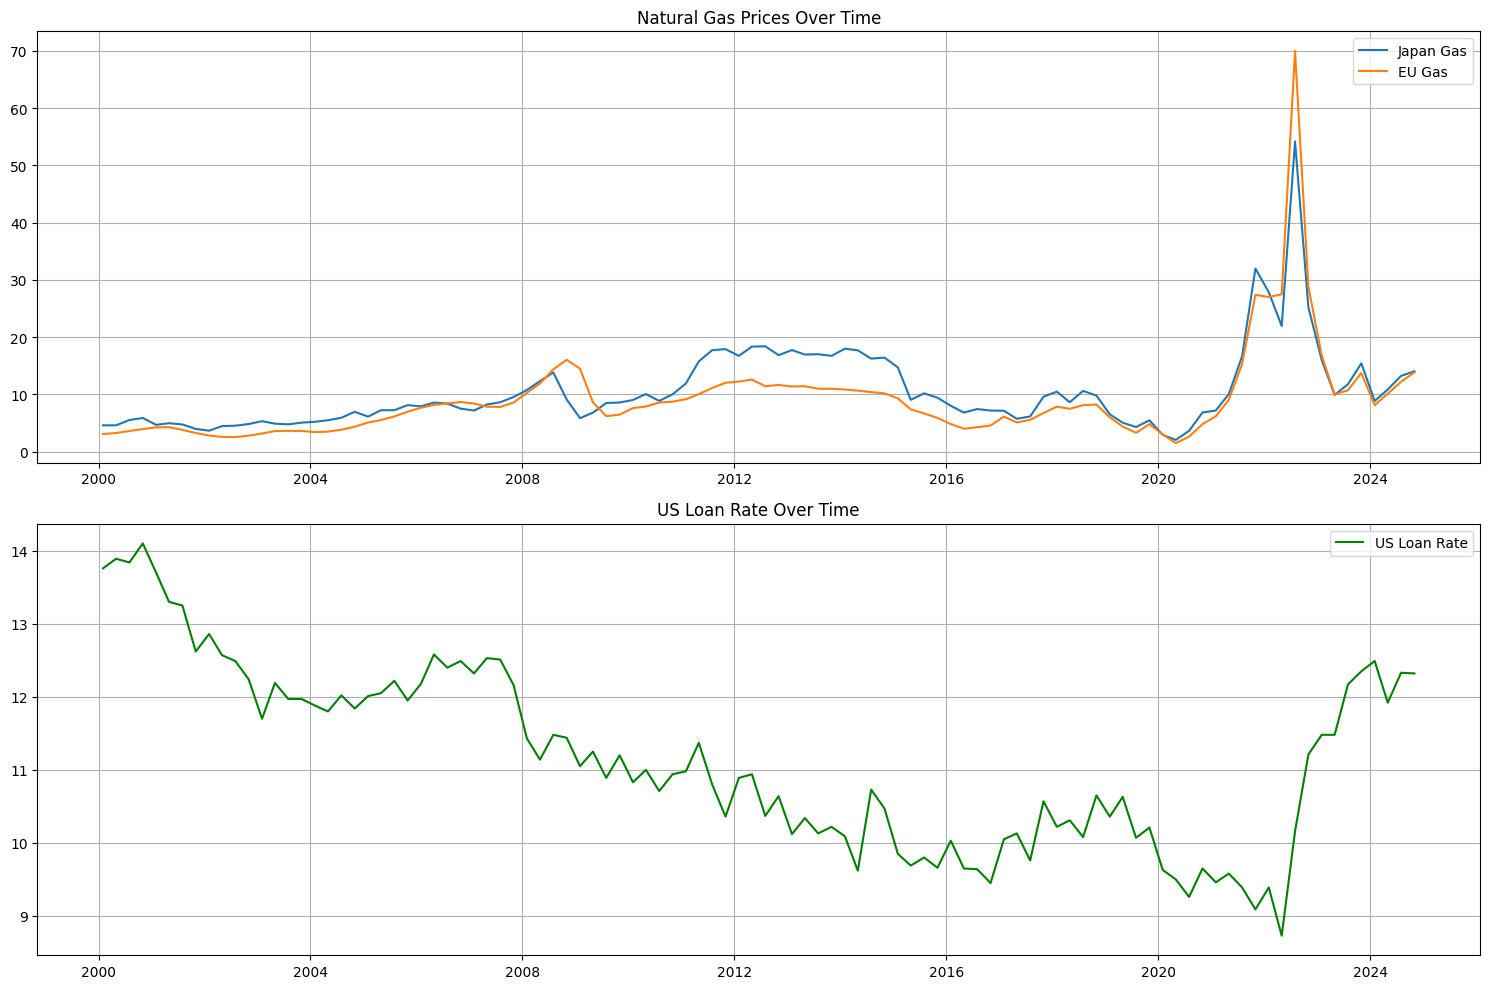

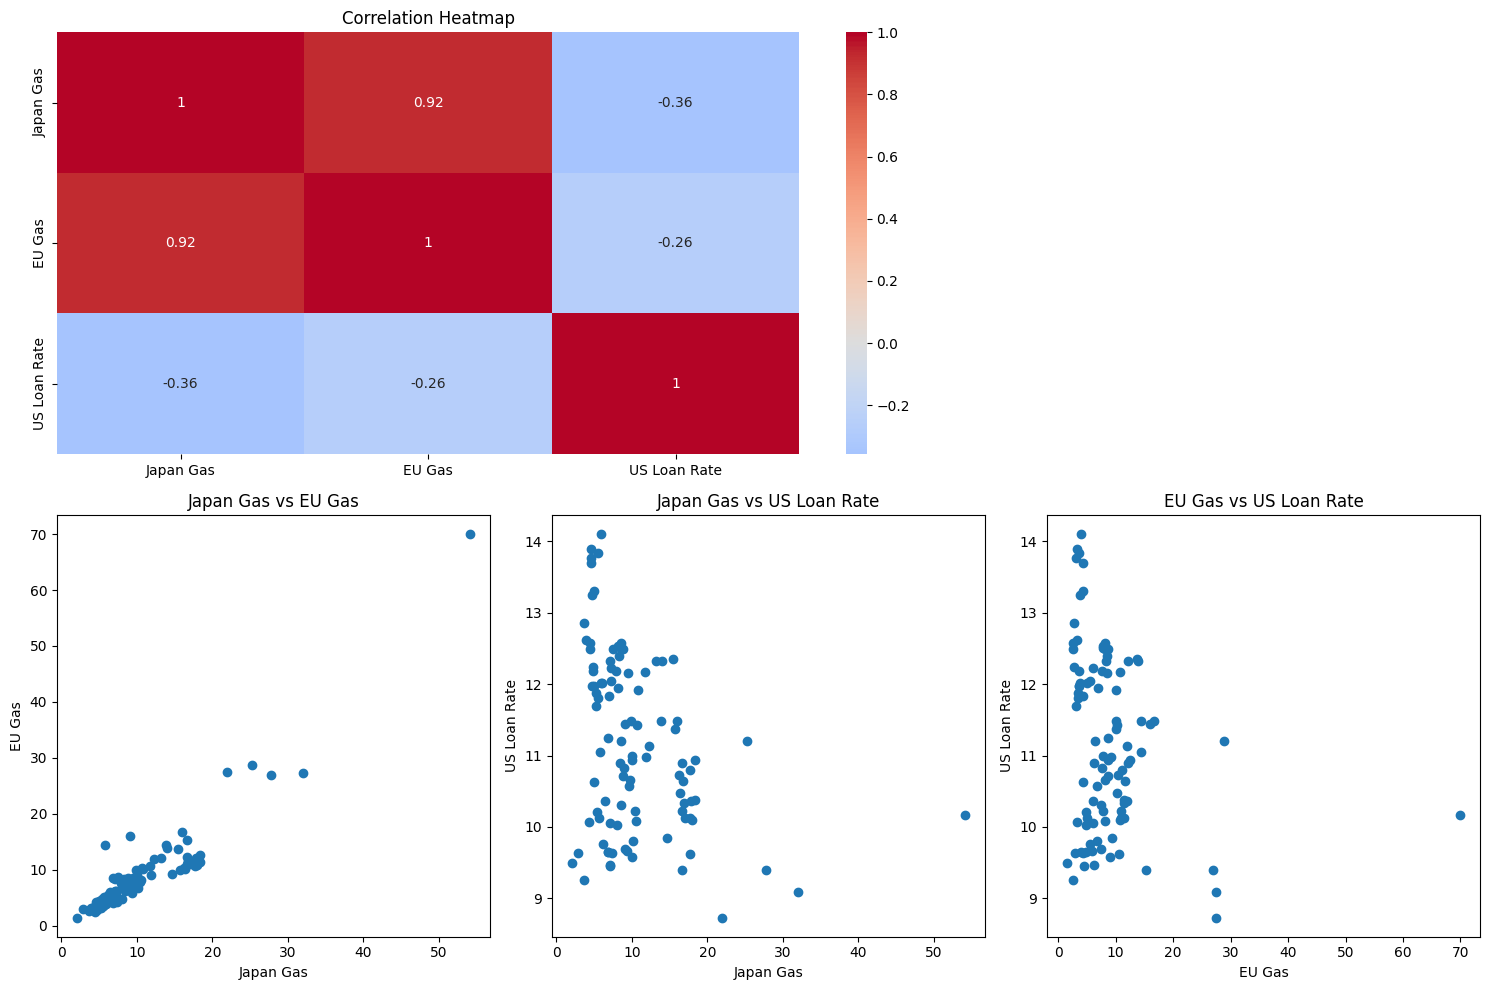


Granger Causality Results (p-values):
----------------------------------------
Japan Gas -> EU Gas: 0.0003 ***
Japan Gas -> US Loan Rate: 0.0014 ***
EU Gas -> Japan Gas: 0.0000 ***
EU Gas -> US Loan Rate: 0.0008 ***
US Loan Rate -> Japan Gas: 0.0081 ***
US Loan Rate -> EU Gas: 0.0005 ***

Significance levels: *** p<0.01, ** p<0.05, * p<0.1


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import requests

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df.set_index('date')['value']
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        return None

def granger_causality(data, max_lag=12):
    results = {}
    for col1 in data.columns:
        for col2 in data.columns:
            if col1 != col2:
                test_result = grangercausalitytests(data[[col1, col2]], maxlag=max_lag, verbose=False)
                min_p_value = min([test_result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)])
                results[f"{col1} -> {col2}"] = min_p_value
    return results

def plot_correlations_and_scatter(data):
    # Create correlation matrix
    corr = data.corr()

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 10))

    # Correlation heatmap
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax1)
    ax1.set_title("Correlation Heatmap")

    # Scatter plots
    ax2 = plt.subplot2grid((2, 3), (1, 0))
    ax2.scatter(data['Japan Gas'], data['EU Gas'])
    ax2.set_xlabel('Japan Gas')
    ax2.set_ylabel('EU Gas')
    ax2.set_title('Japan Gas vs EU Gas')

    ax3 = plt.subplot2grid((2, 3), (1, 1))
    ax3.scatter(data['Japan Gas'], data['US Loan Rate'])
    ax3.set_xlabel('Japan Gas')
    ax3.set_ylabel('US Loan Rate')
    ax3.set_title('Japan Gas vs US Loan Rate')

    ax4 = plt.subplot2grid((2, 3), (1, 2))
    ax4.scatter(data['EU Gas'], data['US Loan Rate'])
    ax4.set_xlabel('EU Gas')
    ax4.set_ylabel('US Loan Rate')
    ax4.set_title('EU Gas vs US Loan Rate')

    plt.tight_layout()
    plt.show()

def plot_time_series(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot gas prices
    ax1.plot(data.index, data['Japan Gas'], label='Japan Gas')
    ax1.plot(data.index, data['EU Gas'], label='EU Gas')
    ax1.set_title('Natural Gas Prices Over Time')
    ax1.legend()
    ax1.grid(True)

    # Plot US Loan Rate
    ax2.plot(data.index, data['US Loan Rate'], label='US Loan Rate', color='green')
    ax2.set_title('US Loan Rate Over Time')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def main():
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Fetch data
    japan_gas = fetch_fred_data('PNGASJPUSDM', api_key)
    eu_gas = fetch_fred_data('PNGASEUUSDM', api_key)
    us_loan_rate = fetch_fred_data('TERMCBPER24NS', api_key)

    # Combine data
    data = pd.concat([japan_gas, eu_gas, us_loan_rate], axis=1)
    data.columns = ['Japan Gas', 'EU Gas', 'US Loan Rate']
    data = data.dropna()

    # Plot time series
    plot_time_series(data)

    # Plot correlations and scatter plots
    plot_correlations_and_scatter(data)

    # Perform and display Granger Causality tests
    gc_results = granger_causality(data)

    print("\nGranger Causality Results (p-values):")
    print("----------------------------------------")
    for pair, p_value in gc_results.items():
        significance = "***" if p_value < 0.01 else "**" if p_value < 0.05 else "*" if p_value < 0.1 else ""
        print(f"{pair}: {p_value:.4f} {significance}")
    print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.1")

if __name__ == "__main__":
    main()


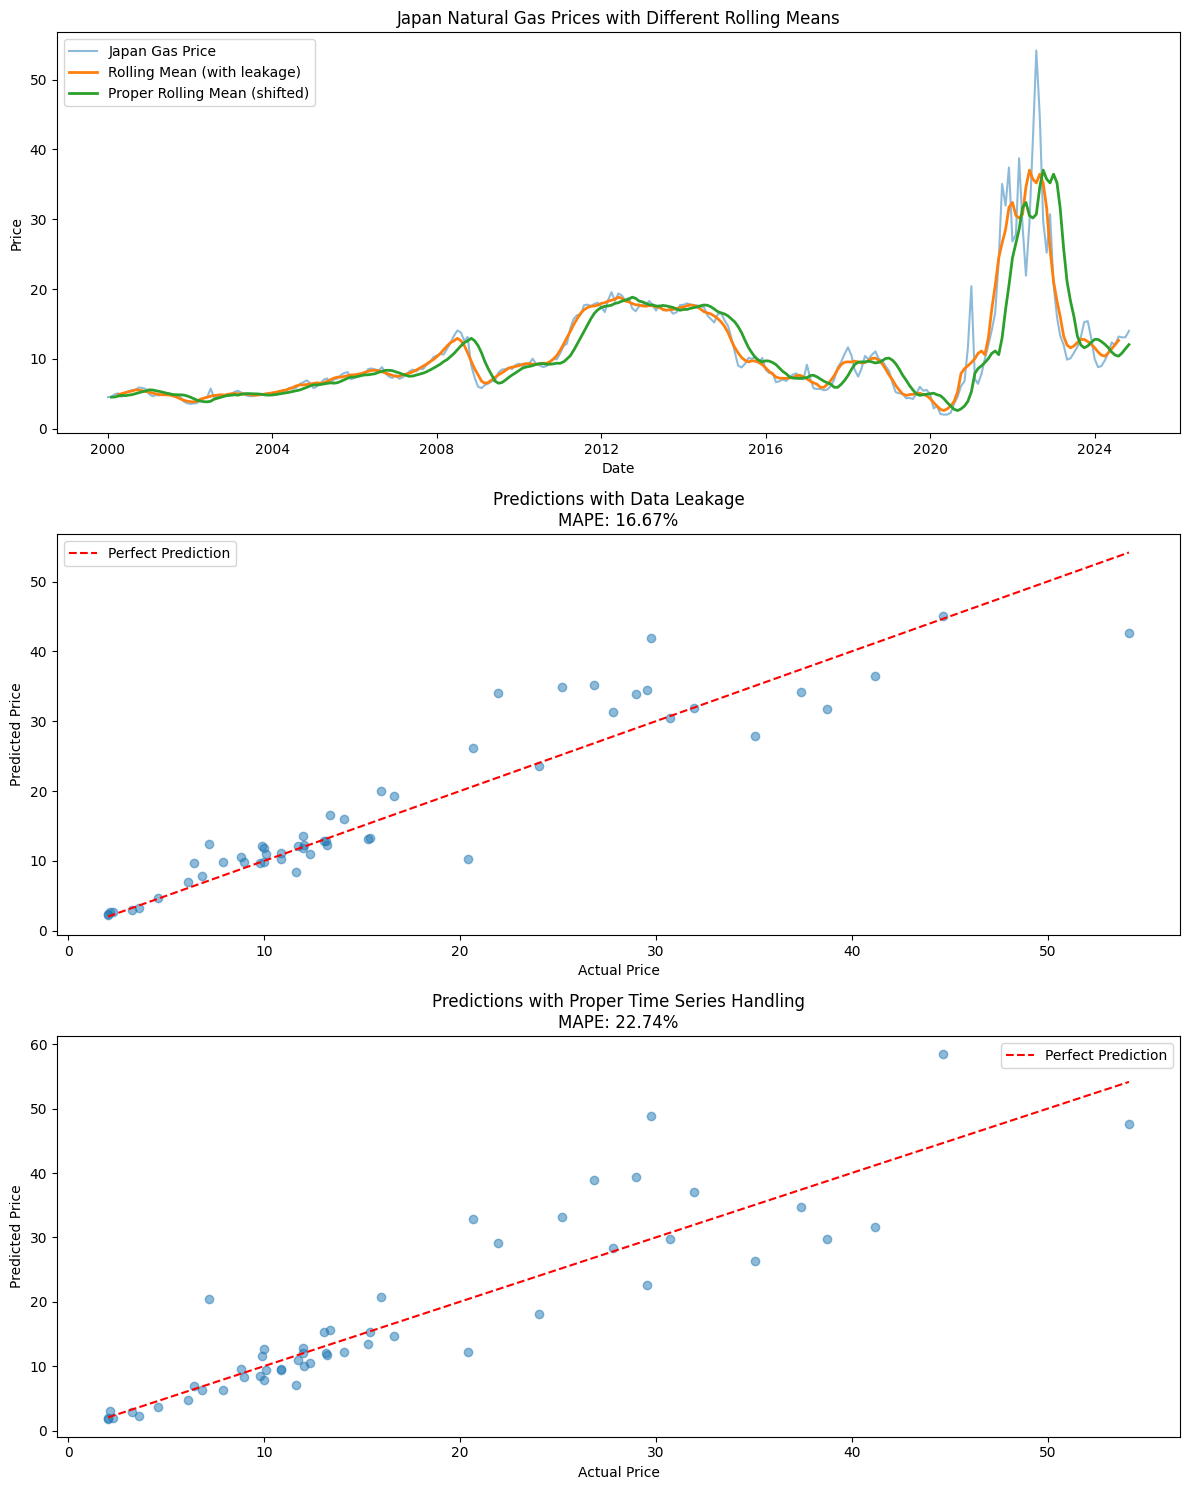

MAPE with data leakage: 16.67%
MAPE without data leakage: 22.74%
Difference in MAPE: 6.07%


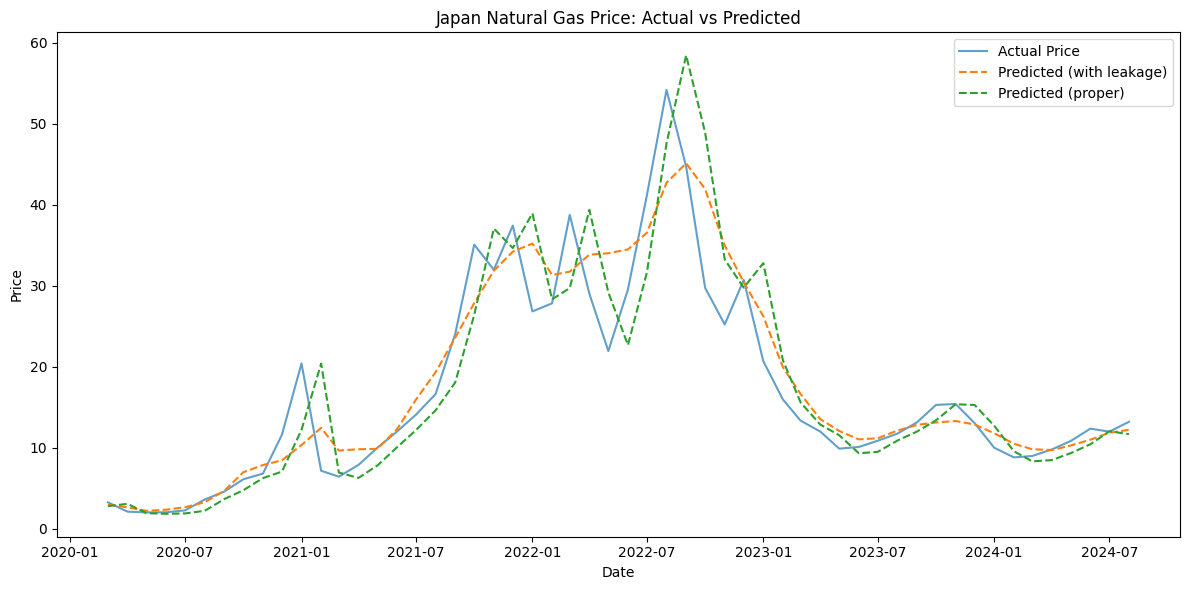

In [19]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fetch Japan natural gas price data
api_key = '8f058d10ec8c788296c040ea09e634d5'
japan_gas = fetch_fred_data('PNGASJPUSDM', api_key)

# Create DataFrame with date index
data = pd.DataFrame({
    'date': japan_gas['date'],
    'price': japan_gas['value']
}).set_index('date')

# Add rolling means
data['rolling_mean_with_leakage'] = data['price'].rolling(window=7, center=True).mean()
data['proper_rolling_mean'] = data['price'].rolling(window=7, min_periods=1).mean().shift(1)

# Add additional features
data['price_lag1'] = data['price'].shift(1)
data['monthly_return'] = data['price'].pct_change(periods=30)

# 1. Model with Data Leakage
def demonstrate_leakage(data):
    data = data.dropna()
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['price_lag1', 'rolling_mean_with_leakage', 'monthly_return']]
    y_train = train_data['price']
    X_test = test_data[['price_lag1', 'rolling_mean_with_leakage', 'monthly_return']]
    y_test = test_data['price']

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return test_data.index, y_test, y_pred

# 2. Model with Proper Handling
def demonstrate_proper_handling(data):
    data = data.dropna()
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['price_lag1', 'proper_rolling_mean', 'monthly_return']]
    y_train = train_data['price']
    X_test = test_data[['price_lag1', 'proper_rolling_mean', 'monthly_return']]
    y_test = test_data['price']

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return test_data.index, y_test, y_pred

# Run both models
test_dates_leak, y_test_leak, y_pred_leak = demonstrate_leakage(data)
test_dates_proper, y_test_proper, y_pred_proper = demonstrate_proper_handling(data)

# Calculate MAPE
mape_leak = mape(y_test_leak, y_pred_leak)
mape_proper = mape(y_test_proper, y_pred_proper)

# Create visualizations
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# 1. Original Data and Rolling Means
ax1.plot(data.index, data['price'], label='Japan Gas Price', alpha=0.5)
ax1.plot(data.index, data['rolling_mean_with_leakage'],
         label='Rolling Mean (with leakage)', linewidth=2)
ax1.plot(data.index, data['proper_rolling_mean'],
         label='Proper Rolling Mean (shifted)', linewidth=2)
ax1.set_title('Japan Natural Gas Prices with Different Rolling Means')
ax1.legend()
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# 2. Model with Data Leakage
ax2.scatter(y_test_leak, y_pred_leak, alpha=0.5)
ax2.plot([y_test_leak.min(), y_test_leak.max()],
         [y_test_leak.min(), y_test_leak.max()],
         'r--', label='Perfect Prediction')
ax2.set_title(f'Predictions with Data Leakage\nMAPE: {mape_leak:.2f}%')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.legend()

# 3. Model with Proper Handling
ax3.scatter(y_test_proper, y_pred_proper, alpha=0.5)
ax3.plot([y_test_proper.min(), y_test_proper.max()],
         [y_test_proper.min(), y_test_proper.max()],
         'r--', label='Perfect Prediction')
ax3.set_title(f'Predictions with Proper Time Series Handling\nMAPE: {mape_proper:.2f}%')
ax3.set_xlabel('Actual Price')
ax3.set_ylabel('Predicted Price')
ax3.legend()

plt.tight_layout()
plt.show()

print(f"MAPE with data leakage: {mape_leak:.2f}%")
print(f"MAPE without data leakage: {mape_proper:.2f}%")
print(f"Difference in MAPE: {mape_proper - mape_leak:.2f}%")

# Plot predictions over time
plt.figure(figsize=(12, 6))
plt.plot(test_dates_leak, y_test_leak, label='Actual Price', alpha=0.7)
plt.plot(test_dates_leak, y_pred_leak, '--', label='Predicted (with leakage)')
plt.plot(test_dates_proper, y_pred_proper, '--', label='Predicted (proper)')
plt.title('Japan Natural Gas Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


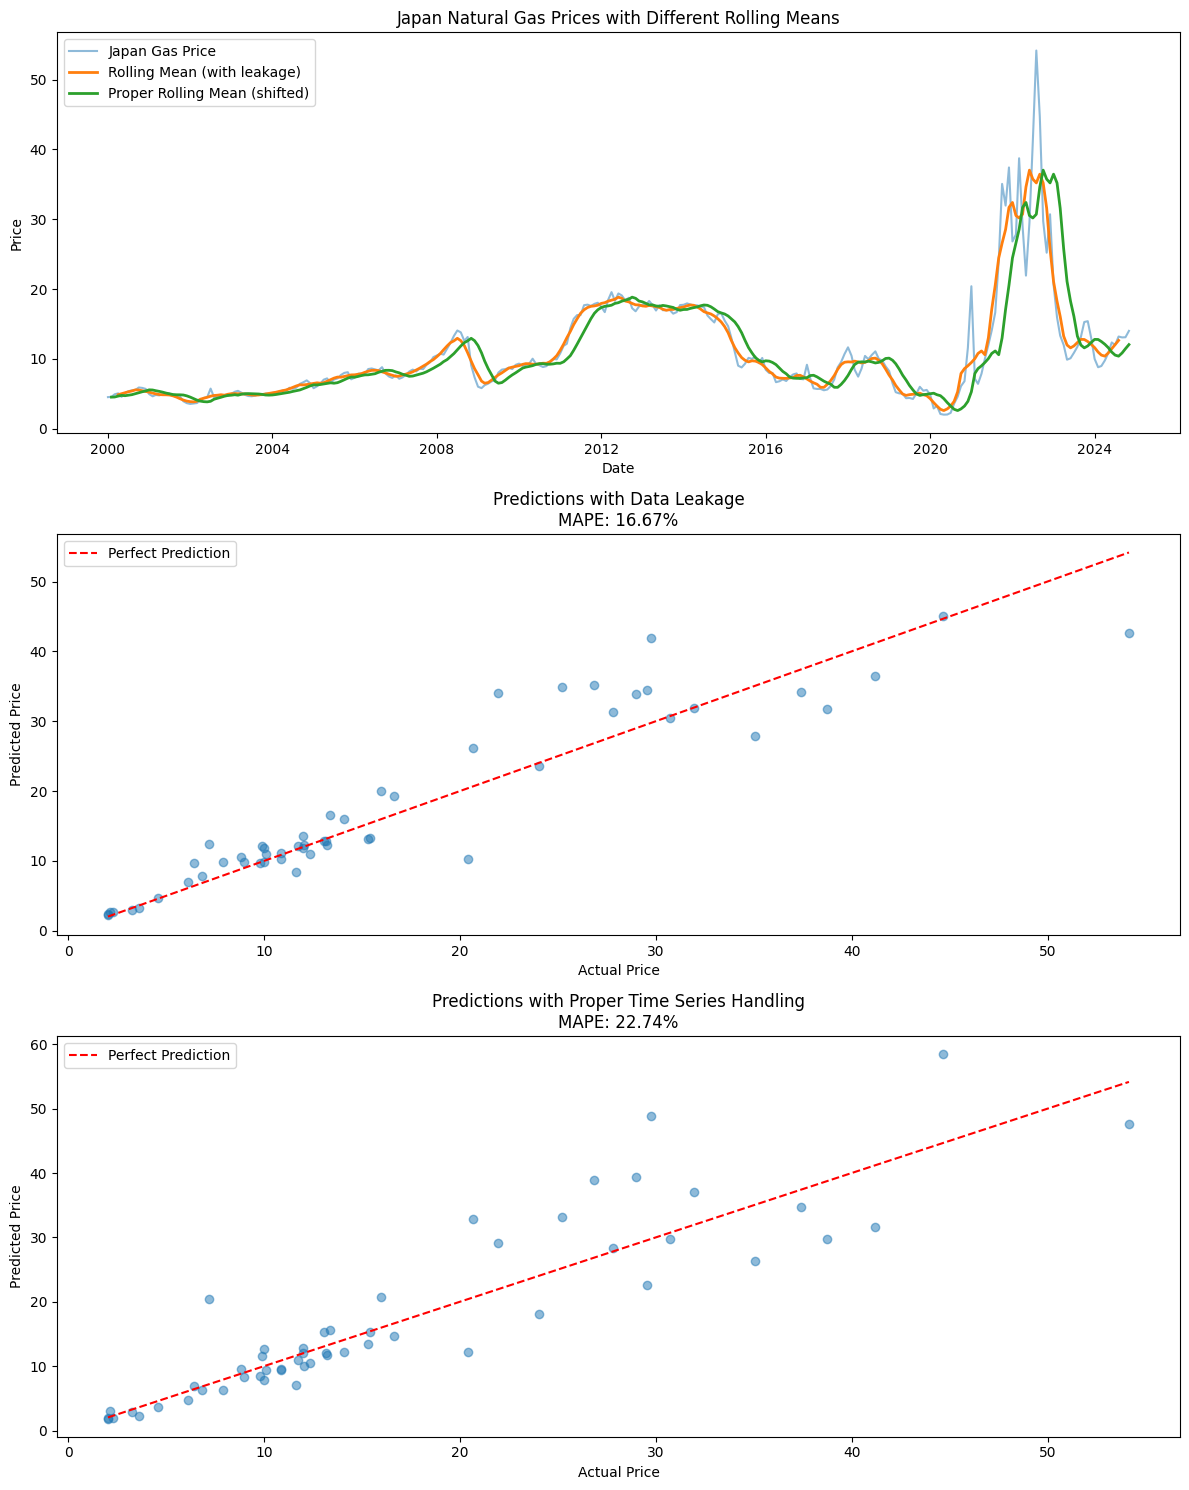

MAPE with data leakage: 16.67%
MAPE without data leakage: 22.74%
Difference in MAPE: 6.07%


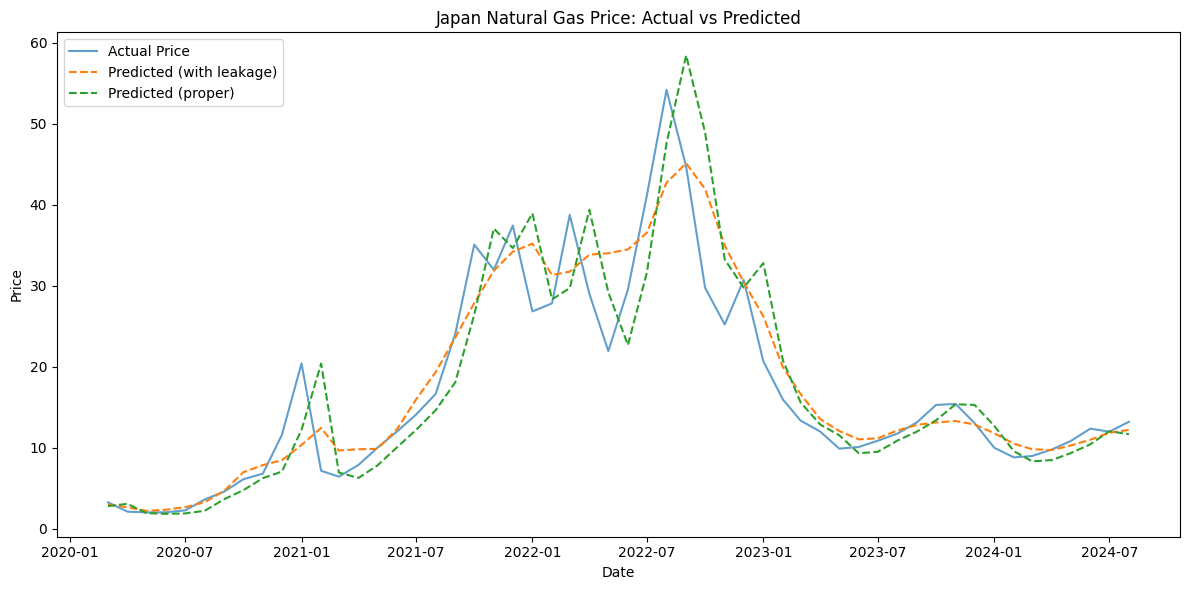

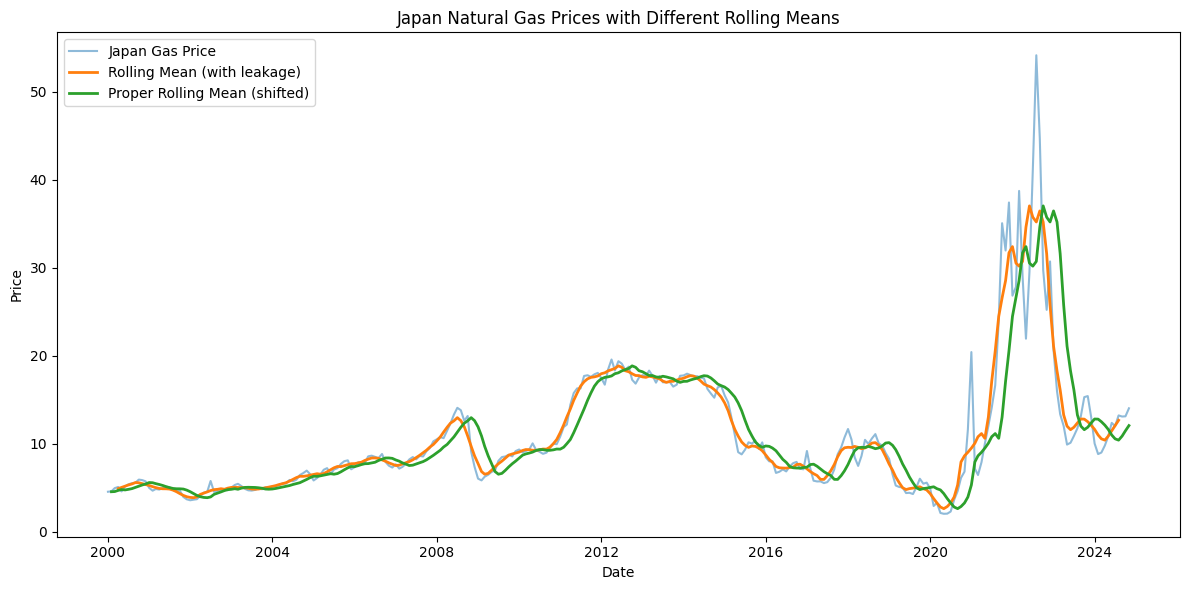

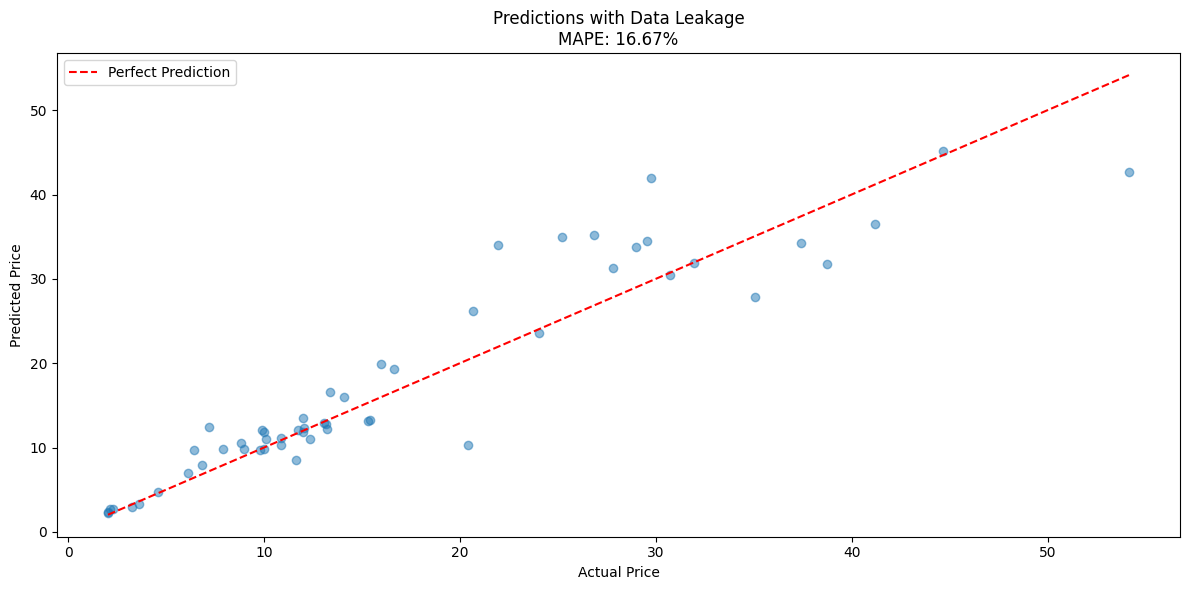

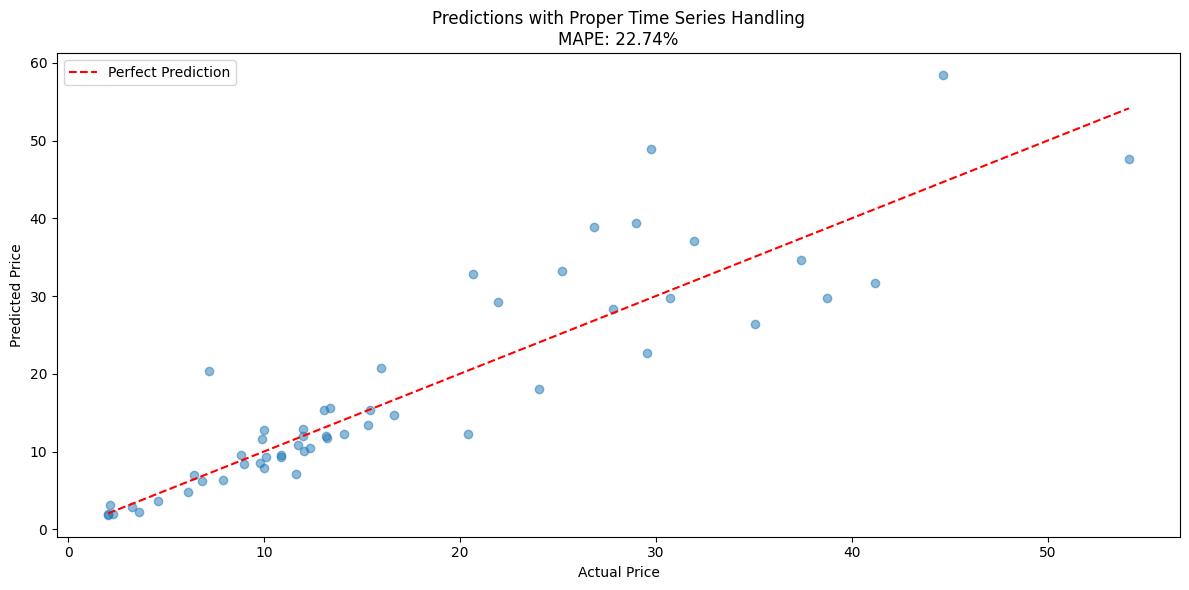

In [20]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fetch Japan natural gas price data
api_key = '8f058d10ec8c788296c040ea09e634d5'
japan_gas = fetch_fred_data('PNGASJPUSDM', api_key)

# Create DataFrame with date index
data = pd.DataFrame({
    'date': japan_gas['date'],
    'price': japan_gas['value']
}).set_index('date')

# Add rolling means
data['rolling_mean_with_leakage'] = data['price'].rolling(window=7, center=True).mean()
data['proper_rolling_mean'] = data['price'].rolling(window=7, min_periods=1).mean().shift(1)

# Add additional features
data['price_lag1'] = data['price'].shift(1)
data['monthly_return'] = data['price'].pct_change(periods=30)

# Model functions remain the same
def demonstrate_leakage(data):
    data = data.dropna()
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['price_lag1', 'rolling_mean_with_leakage', 'monthly_return']]
    y_train = train_data['price']
    X_test = test_data[['price_lag1', 'rolling_mean_with_leakage', 'monthly_return']]
    y_test = test_data['price']

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return test_data.index, y_test, y_pred

def demonstrate_proper_handling(data):
    data = data.dropna()
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['price_lag1', 'proper_rolling_mean', 'monthly_return']]
    y_train = train_data['price']
    X_test = test_data[['price_lag1', 'proper_rolling_mean', 'monthly_return']]
    y_test = test_data['price']

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return test_data.index, y_test, y_pred

# Run both models
test_dates_leak, y_test_leak, y_pred_leak = demonstrate_leakage(data)
test_dates_proper, y_test_proper, y_pred_proper = demonstrate_proper_handling(data)

# Calculate MAPE
mape_leak = mape(y_test_leak, y_pred_leak)
mape_proper = mape(y_test_proper, y_pred_proper)

# Create and save main visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# 1. Original Data and Rolling Means
ax1.plot(data.index, data['price'], label='Japan Gas Price', alpha=0.5)
ax1.plot(data.index, data['rolling_mean_with_leakage'],
         label='Rolling Mean (with leakage)', linewidth=2)
ax1.plot(data.index, data['proper_rolling_mean'],
         label='Proper Rolling Mean (shifted)', linewidth=2)
ax1.set_title('Japan Natural Gas Prices with Different Rolling Means')
ax1.legend(loc='upper left')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# 2. Model with Data Leakage
ax2.scatter(y_test_leak, y_pred_leak, alpha=0.5)
ax2.plot([y_test_leak.min(), y_test_leak.max()],
         [y_test_leak.min(), y_test_leak.max()],
         'r--', label='Perfect Prediction')
ax2.set_title(f'Predictions with Data Leakage\nMAPE: {mape_leak:.2f}%')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.legend(loc='upper left')

# 3. Model with Proper Handling
ax3.scatter(y_test_proper, y_pred_proper, alpha=0.5)
ax3.plot([y_test_proper.min(), y_test_proper.max()],
         [y_test_proper.min(), y_test_proper.max()],
         'r--', label='Perfect Prediction')
ax3.set_title(f'Predictions with Proper Time Series Handling\nMAPE: {mape_proper:.2f}%')
ax3.set_xlabel('Actual Price')
ax3.set_ylabel('Predicted Price')
ax3.legend(loc='upper left')

plt.tight_layout()
plt.savefig('japan_gas_analysis_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"MAPE with data leakage: {mape_leak:.2f}%")
print(f"MAPE without data leakage: {mape_proper:.2f}%")
print(f"Difference in MAPE: {mape_proper - mape_leak:.2f}%")

# Create and save time series comparison plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates_leak, y_test_leak, label='Actual Price', alpha=0.7)
plt.plot(test_dates_leak, y_pred_leak, '--', label='Predicted (with leakage)')
plt.plot(test_dates_proper, y_pred_proper, '--', label='Predicted (proper)')
plt.title('Japan Natural Gas Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('japan_gas_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create and save individual plots for better detail
# 1. Rolling Means Plot
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Japan Gas Price', alpha=0.5)
plt.plot(data.index, data['rolling_mean_with_leakage'],
         label='Rolling Mean (with leakage)', linewidth=2)
plt.plot(data.index, data['proper_rolling_mean'],
         label='Proper Rolling Mean (shifted)', linewidth=2)
plt.title('Japan Natural Gas Prices with Different Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('japan_gas_rolling_means.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Leakage Model Predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test_leak, y_pred_leak, alpha=0.5)
plt.plot([y_test_leak.min(), y_test_leak.max()],
         [y_test_leak.min(), y_test_leak.max()],
         'r--', label='Perfect Prediction')
plt.title(f'Predictions with Data Leakage\nMAPE: {mape_leak:.2f}%')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('japan_gas_leakage_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Proper Model Predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test_proper, y_pred_proper, alpha=0.5)
plt.plot([y_test_proper.min(), y_test_proper.max()],
         [y_test_proper.min(), y_test_proper.max()],
         'r--', label='Perfect Prediction')
plt.title(f'Predictions with Proper Time Series Handling\nMAPE: {mape_proper:.2f}%')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('japan_gas_proper_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


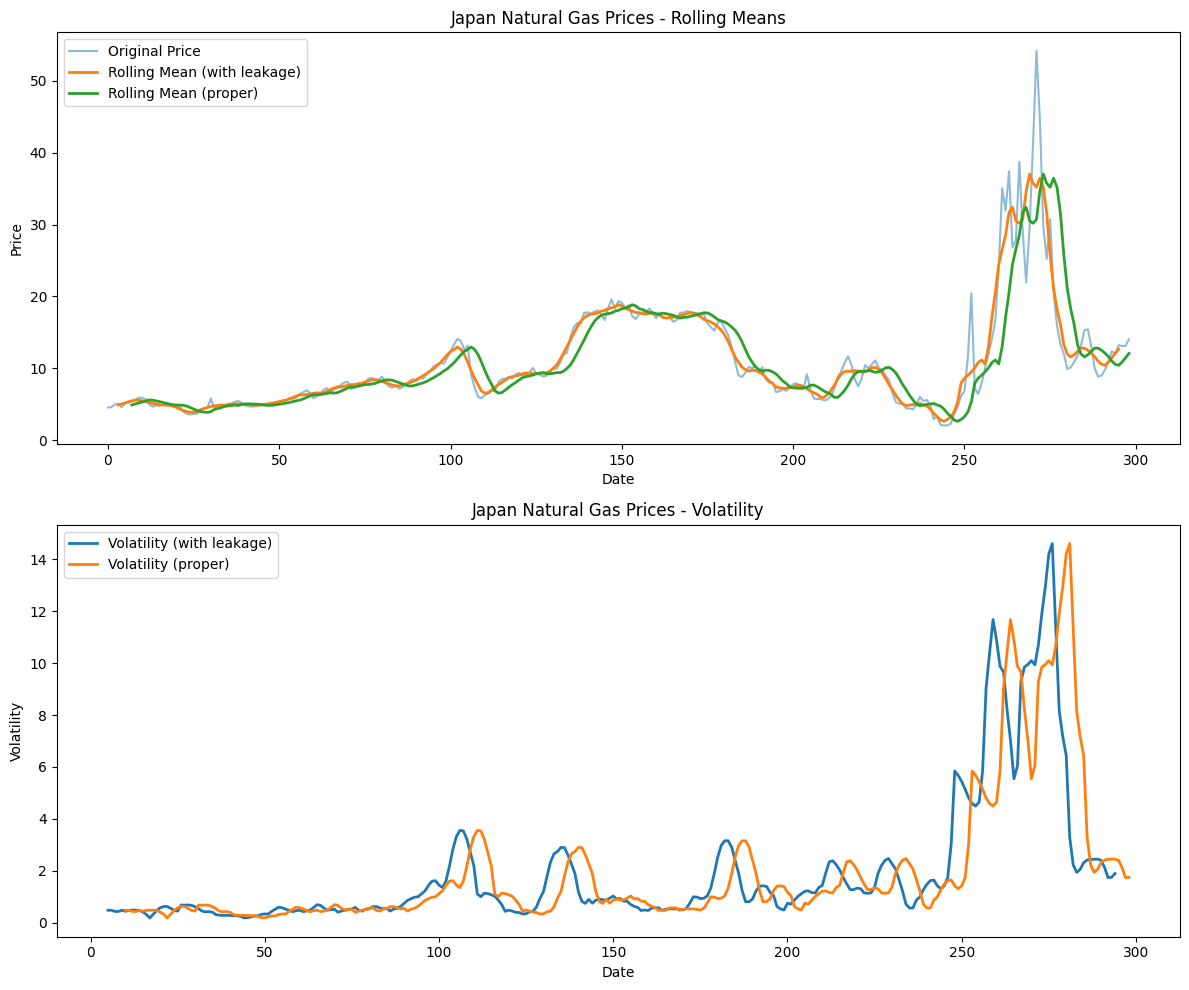

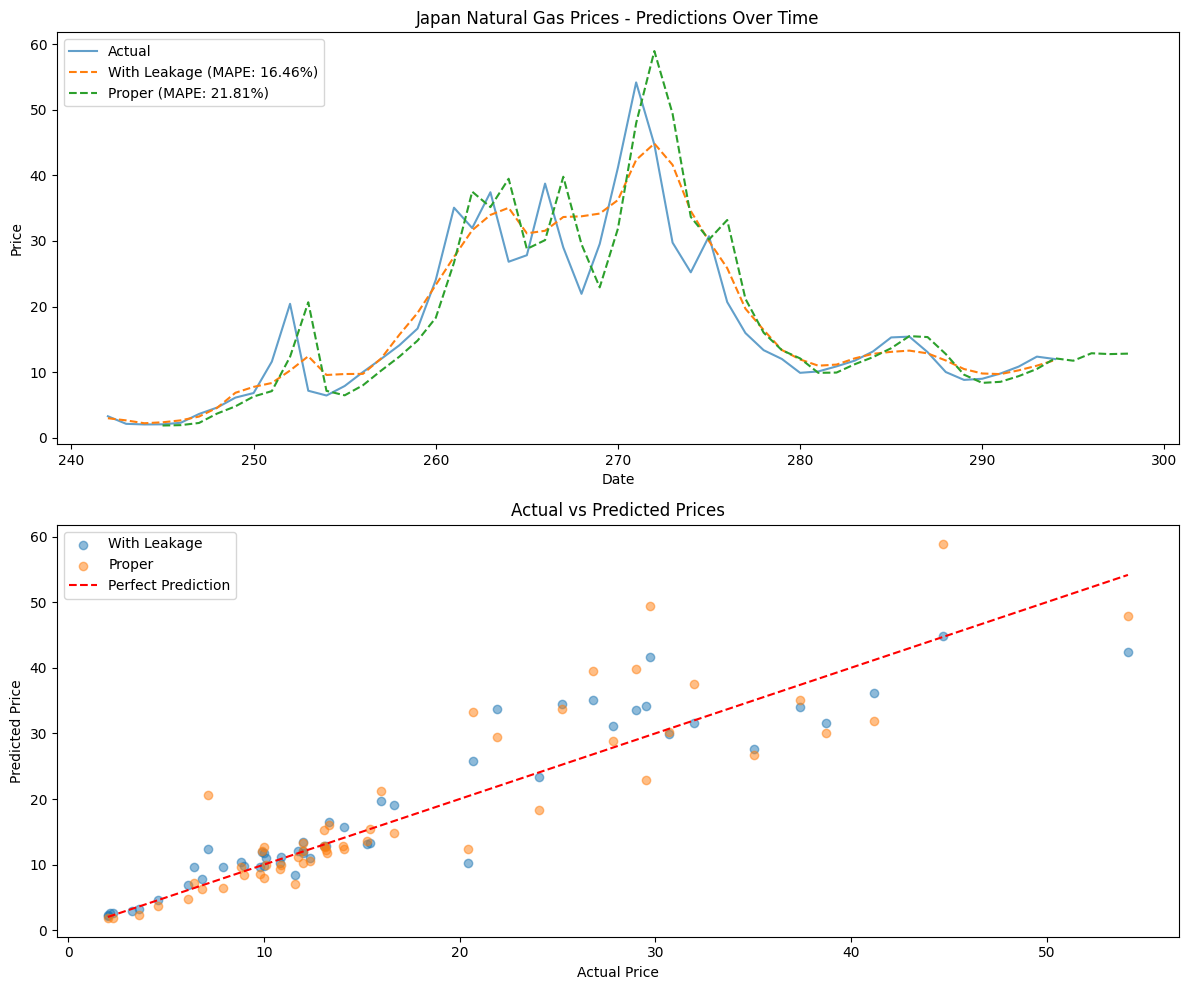

MAPE with leakage: 16.46%
MAPE without leakage: 21.81%
Difference in MAPE: 5.35%


In [23]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    """Fetch data from FRED API"""
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_features(df, leakage=False):
    """Create features with or without data leakage"""
    df = df.copy()
    if leakage:
        df['rolling_mean'] = df['value'].rolling(window=7, center=True).mean()
        df['volatility'] = df['value'].rolling(window=10, center=True).std()
    else:
        df['rolling_mean'] = df['value'].rolling(window=7).mean().shift(1)
        df['volatility'] = df['value'].rolling(window=10).std().shift(1)

    df['price_lag'] = df['value'].shift(1)
    df['monthly_return'] = df['value'].pct_change(periods=30)
    return df

def train_model(data, features, target='value'):
    """Train and evaluate model"""
    data = data.dropna()
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return test_data.index, y_test, y_pred

def plot_features(data, leakage_data, proper_data, title, filename):
    """Plot feature comparison for leakage and proper handling"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot rolling means
    ax1.plot(data.index, data['value'], label='Original Price', alpha=0.5)
    ax1.plot(leakage_data.index, leakage_data['rolling_mean'],
             label='Rolling Mean (with leakage)', linewidth=2)
    ax1.plot(proper_data.index, proper_data['rolling_mean'],
             label='Rolling Mean (proper)', linewidth=2)
    ax1.set_title(f'{title} - Rolling Means')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')

    # Plot volatility
    ax2.plot(leakage_data.index, leakage_data['volatility'],
             label='Volatility (with leakage)', linewidth=2)
    ax2.plot(proper_data.index, proper_data['volatility'],
             label='Volatility (proper)', linewidth=2)
    ax2.set_title(f'{title} - Volatility')
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volatility')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def plot_predictions(leakage_results, proper_results, title, filename):
    """Plot prediction results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Unpack results
    dates_leak, y_test_leak, y_pred_leak = leakage_results
    dates_proper, y_test_proper, y_pred_proper = proper_results

    # Calculate MAPE
    mape_leak = mape(y_test_leak, y_pred_leak)
    mape_proper = mape(y_test_proper, y_pred_proper)

    # Time series predictions
    ax1.plot(dates_leak, y_test_leak, label='Actual', alpha=0.7)
    ax1.plot(dates_leak, y_pred_leak, '--', label=f'With Leakage (MAPE: {mape_leak:.2f}%)')
    ax1.plot(dates_proper, y_pred_proper, '--', label=f'Proper (MAPE: {mape_proper:.2f}%)')
    ax1.set_title(f'{title} - Predictions Over Time')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')

    # Scatter plots
    ax2.scatter(y_test_leak, y_pred_leak, alpha=0.5, label='With Leakage')
    ax2.scatter(y_test_proper, y_pred_proper, alpha=0.5, label='Proper')
    ax2.plot([min(y_test_leak.min(), y_test_proper.min()),
              max(y_test_leak.max(), y_test_proper.max())],
             [min(y_test_leak.min(), y_test_proper.min()),
              max(y_test_leak.max(), y_test_proper.max())],
             'r--', label='Perfect Prediction')
    ax2.set_title('Actual vs Predicted Prices')
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Actual Price')
    ax2.set_ylabel('Predicted Price')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def main():
    api_key = '8f058d10ec8c788296c040ea09e634d5'

    # Fetch data
    japan_gas = fetch_fred_data('PNGASJPUSDM', api_key)

    # Data Leakage Analysis
    data_with_leakage = create_features(japan_gas, leakage=True)
    data_proper = create_features(japan_gas, leakage=False)

    # Plot feature comparison
    plot_features(japan_gas, data_with_leakage, data_proper,
                 'Japan Natural Gas Prices', 'japan_gas_features.png')

    # Train models
    features_leak = ['rolling_mean', 'volatility', 'price_lag', 'monthly_return']
    features_proper = ['rolling_mean', 'volatility', 'price_lag', 'monthly_return']

    leakage_results = train_model(data_with_leakage, features_leak)
    proper_results = train_model(data_proper, features_proper)

    # Plot prediction results
    plot_predictions(leakage_results, proper_results,
                    'Japan Natural Gas Prices', 'japan_gas_predictions.png')

    # Calculate and print MAPE
    _, y_test_leak, y_pred_leak = leakage_results
    _, y_test_proper, y_pred_proper = proper_results

    mape_leak = mape(y_test_leak, y_pred_leak)
    mape_proper = mape(y_test_proper, y_pred_proper)

    print(f"MAPE with leakage: {mape_leak:.2f}%")
    print(f"MAPE without leakage: {mape_proper:.2f}%")
    print(f"Difference in MAPE: {mape_proper - mape_leak:.2f}%")

if __name__ == "__main__":
    main()


In [24]:
# Function to create features (wrong way - with lookahead bias)
def create_features_with_lookahead(df):
    df['next_day_price'] = df['value'].shift(-1)  # Target (tomorrow's price)
    df['future_5day_ma'] = df['value'].rolling(window=5, center=True).mean()
    df['future_volatility'] = df['value'].rolling(window=10, center=True).std()
    return df

# Function to create features (correct way - no lookahead)
def create_features_proper(df):
    df['next_day_price'] = df['value'].shift(-1)  # Target (tomorrow's price)
    df['past_5day_ma'] = df['value'].rolling(window=5).mean()
    df['past_volatility'] = df['value'].rolling(window=10).std()
    return df

# Function to train and evaluate model with proper time series split
def evaluate_model(data, features, title, ax):
    # Remove NaN values
    data = data.dropna()

    # Proper time series split (80% train, 20% test)
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    # Prepare features and target
    X_train = train_data[features]
    y_train = train_data['next_day_price']
    X_test = test_data[features]
    y_test = test_data['next_day_price']

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    mape_score = mape(y_test, y_pred)

    # Plot results
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            'r--', label='Perfect Prediction')
    ax.set_title(f'{title}\nMAPE: {mape_score:.2f}%')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()

    return mape_score, test_data.index, y_test, y_pred

def main():
    # FRED API key
    api_key = 'YOUR8f058d10ec8c788296c040ea09e634d5_KEY'

    # Fetch US Natural Gas data
    gas_data = fetch_fred_data('PNGASUSUSDM', api_key)
    gas_data = gas_data.set_index('date')

    # Create both datasets
    data_with_lookahead = create_features_with_lookahead(gas_data.copy())
    data_proper = create_features_proper(gas_data.copy())

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Evaluate both models
    mape_lookahead, test_dates_look, y_test_look, y_pred_look = evaluate_model(
        data_with_lookahead,
        ['future_5day_ma', 'future_volatility'],
        'Model with Lookahead Bias',
        ax1
    )

    mape_proper, test_dates_prop, y_test_prop, y_pred_prop = evaluate_model(
        data_proper,
        ['past_5day_ma', 'past_volatility'],
        'Model without Lookahead Bias',
        ax2
    )

    plt.tight_layout()
    plt.show()

    # Print comparison
    print(f"MAPE with lookahead bias: {mape_lookahead:.2f}%")
    print(f"MAPE without lookahead bias: {mape_proper:.2f}%")
    print(f"Difference in MAPE: {mape_proper - mape_lookahead:.2f}%")

    # Plot time series predictions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot actual vs predicted prices over time
    ax1.plot(test_dates_look, y_test_look, label='Actual Price', alpha=0.7)
    ax1.plot(test_dates_look, y_pred_look, label='Predicted (with lookahead)', linestyle='--')
    ax1.set_title(f'Price Predictions with Lookahead Bias (MAPE: {mape_lookahead:.2f}%)')
    ax1.legend()

    ax2.plot(test_dates_prop, y_test_prop, label='Actual Price', alpha=0.7)
    ax2.plot(test_dates_prop, y_pred_prop, label='Predicted (proper)', linestyle='--')
    ax2.set_title(f'Price Predictions without Lookahead Bias (MAPE: {mape_proper:.2f}%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Visualize the features
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Plot moving averages
    ax1.plot(gas_data.index, gas_data['value'], label='Price', alpha=0.5)
    ax1.plot(data_with_lookahead.index, data_with_lookahead['future_5day_ma'],
             label='5-day MA (with lookahead)', linewidth=2)
    ax1.plot(data_proper.index, data_proper['past_5day_ma'],
             label='5-day MA (proper)', linewidth=2)
    ax1.set_title('Price and Moving Averages')
    ax1.legend()

    # Plot volatility
    ax2.plot(data_with_lookahead.index, data_with_lookahead['future_volatility'],
             label='Volatility (with lookahead)', linewidth=2)
    ax2.plot(data_proper.index, data_proper['past_volatility'],
             label='Volatility (proper)', linewidth=2)
    ax2.set_title('Volatility Measures')
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

AttributeError: 'NoneType' object has no attribute 'set_index'

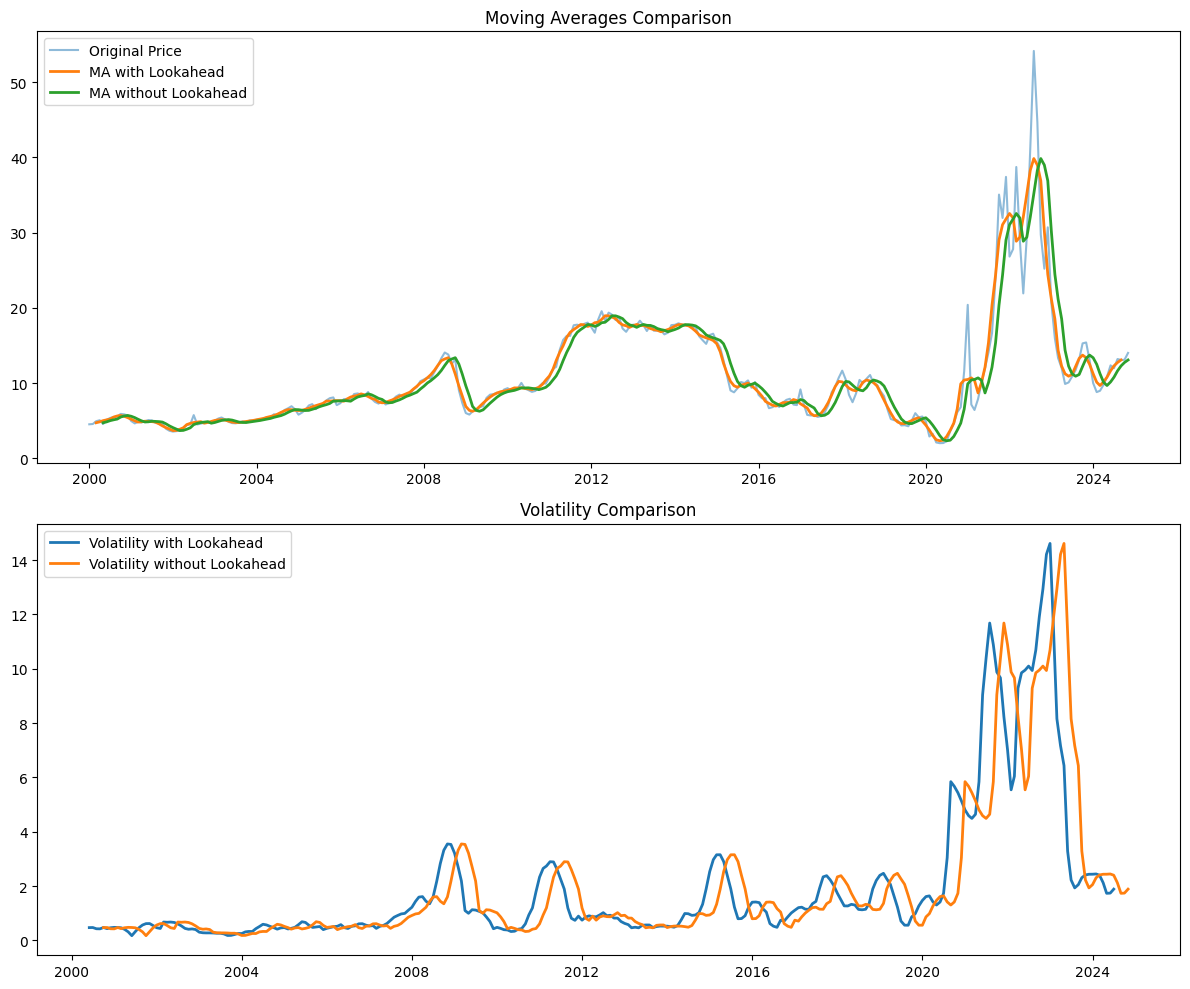

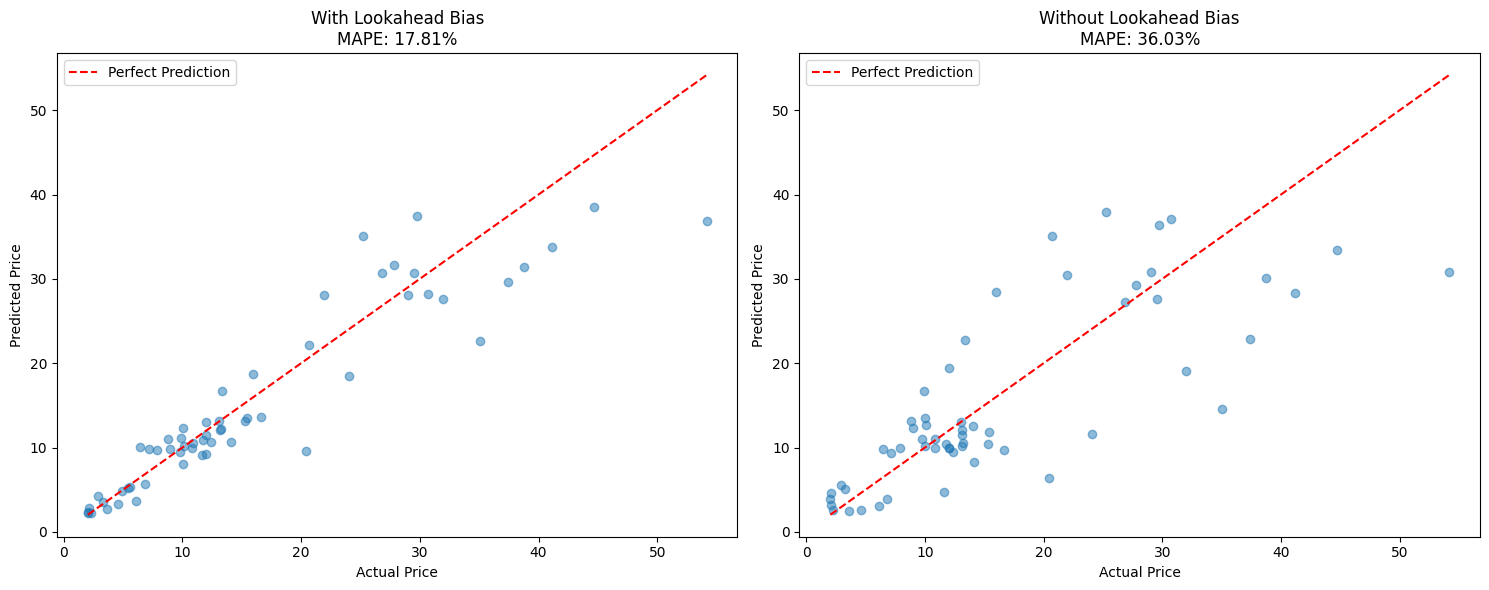

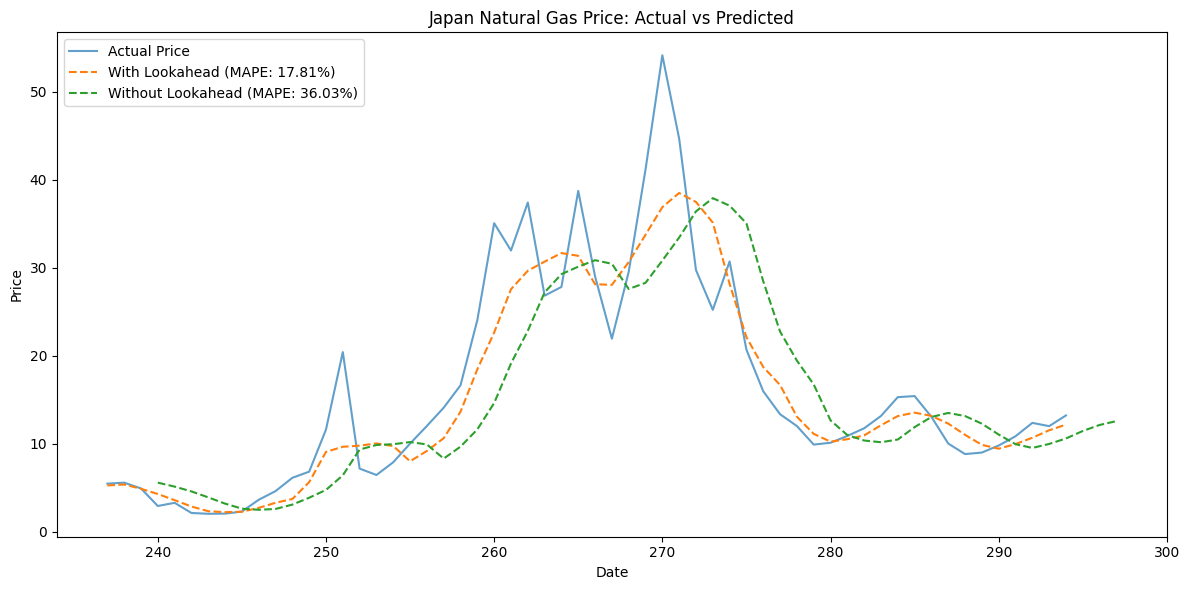


Performance Metrics:
--------------------------------------------------
MAPE with lookahead bias: 17.81%
MAPE without lookahead bias: 36.03%
Difference in MAPE: 18.22%


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

def fetch_fred_data(series_id, api_key, start_date='2000-01-01'):
    """Fetch data from FRED API"""
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fetch Japan natural gas price data
api_key = '8f058d10ec8c788296c040ea09e634d5'
japan_gas = fetch_fred_data('PNGASJPUSDM', api_key)

# Create DataFrame with date index
data = japan_gas.copy()

# Create features with lookahead bias
data_with_lookahead = data.copy()
data_with_lookahead['next_day_price'] = data_with_lookahead['value'].shift(-1)
data_with_lookahead['future_5day_ma'] = data_with_lookahead['value'].rolling(window=5, center=True).mean()
data_with_lookahead['future_volatility'] = data_with_lookahead['value'].rolling(window=10, center=True).std()

# Create features without lookahead bias
data_proper = data.copy()
data_proper['next_day_price'] = data_proper['value'].shift(-1)
data_proper['past_5day_ma'] = data_proper['value'].rolling(window=5).mean()
data_proper['past_volatility'] = data_proper['value'].rolling(window=10).std()

# Function to train and evaluate model
def evaluate_model(data, features):
    data = data.dropna()
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[features]
    y_train = train_data['next_day_price']
    X_test = test_data[features]
    y_test = test_data['next_day_price']

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return test_data.index, y_test, y_pred

# Train both models
test_dates_leak, y_test_leak, y_pred_leak = evaluate_model(
    data_with_lookahead, ['future_5day_ma', 'future_volatility'])
test_dates_proper, y_test_proper, y_pred_proper = evaluate_model(
    data_proper, ['past_5day_ma', 'past_volatility'])

# Calculate MAPE
mape_leak = mape(y_test_leak, y_pred_leak)
mape_proper = mape(y_test_proper, y_pred_proper)

# 1. Feature Comparison Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot moving averages
ax1.plot(data['date'], data['value'], label='Original Price', alpha=0.5)
ax1.plot(data_with_lookahead['date'], data_with_lookahead['future_5day_ma'],
         label='MA with Lookahead', linewidth=2)
ax1.plot(data_proper['date'], data_proper['past_5day_ma'],
         label='MA without Lookahead', linewidth=2)
ax1.set_title('Moving Averages Comparison')
ax1.legend(loc='upper left')
ax1.grid(False)

# Plot volatility
ax2.plot(data_with_lookahead['date'], data_with_lookahead['future_volatility'],
         label='Volatility with Lookahead', linewidth=2)
ax2.plot(data_proper['date'], data_proper['past_volatility'],
         label='Volatility without Lookahead', linewidth=2)
ax2.set_title('Volatility Comparison')
ax2.legend(loc='upper left')
ax2.grid(False)

plt.tight_layout()
plt.savefig('japan_gas_features.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Model Performance Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Lookahead model scatter plot
ax1.scatter(y_test_leak, y_pred_leak, alpha=0.5)
ax1.plot([y_test_leak.min(), y_test_leak.max()],
         [y_test_leak.min(), y_test_leak.max()],
         'r--', label='Perfect Prediction')
ax1.set_title(f'With Lookahead Bias\nMAPE: {mape_leak:.2f}%')
ax1.set_xlabel('Actual Price')
ax1.set_ylabel('Predicted Price')
ax1.legend(loc='upper left')
ax1.grid(False)

# Proper model scatter plot
ax2.scatter(y_test_proper, y_pred_proper, alpha=0.5)
ax2.plot([y_test_proper.min(), y_test_proper.max()],
         [y_test_proper.min(), y_test_proper.max()],
         'r--', label='Perfect Prediction')
ax2.set_title(f'Without Lookahead Bias\nMAPE: {mape_proper:.2f}%')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Predicted Price')
ax2.legend(loc='upper left')
ax2.grid(False)

plt.tight_layout()
plt.savefig('japan_gas_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Time Series Predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates_leak, y_test_leak, label='Actual Price', alpha=0.7)
plt.plot(test_dates_leak, y_pred_leak, '--', label=f'With Lookahead (MAPE: {mape_leak:.2f}%)')
plt.plot(test_dates_proper, y_pred_proper, '--', label=f'Without Lookahead (MAPE: {mape_proper:.2f}%)')
plt.title('Japan Natural Gas Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.savefig('japan_gas_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("-" * 50)
print(f"MAPE with lookahead bias: {mape_leak:.2f}%")
print(f"MAPE without lookahead bias: {mape_proper:.2f}%")
print(f"Difference in MAPE: {mape_proper - mape_leak:.2f}%")
